# 0. Setup

In [1]:
# Verify we're in the correct working directory
import os
import git 
from pathlib import Path

def get_project_root():
    return Path(git.Repo('.', search_parent_directories=True).working_tree_dir)

root = get_project_root()

os.chdir(root)
os.getcwd()

'/Users/seraphinashi/Desktop/DataFusion/DrugResponse_Omics_Molecules'

In [2]:
plot_folder = "images/simulation/"

## import packages, models, trainers

In [3]:
import argparse
import logging
import sys
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

print('pytorch version:', torch.__version__)
print('orig num threads:', torch.get_num_threads())

pytorch version: 1.13.1
orig num threads: 4


In [4]:
from models import *
from trainers import *
from losses import *
from utils import *

In [5]:
import random
seed=42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Prepare dataset

## Load 

In [6]:
simu_folder = "data/simulations"
RNAseq = pd.read_csv(os.path.join(simu_folder, "simu2_RNAseq.csv"), index_col = 0)
RNAseq_meta = pd.read_csv(os.path.join(simu_folder, "simu2_RNAseq_meta.csv"), index_col = 0)
d_fp = pd.read_csv(os.path.join(simu_folder, "simu2_d_fp.csv"), index_col = 0)
cdr = pd.read_csv(os.path.join(simu_folder, "simu2_cdr.csv"), index_col = 0)


# originally
c_meta, meta_map = get_CCL_meta_codes(RNAseq.columns.values, RNAseq_meta)
print(f"Cancer type coding map: {meta_map}")
print(f"Count of each coded cancer type:")
print(c_meta['code'].value_counts())

Cancer type coding map: [('grp3', 2) ('grp2', 1) ('grp1', 0)]
Count of each coded cancer type:
2    62
1    41
0    35
Name: code, dtype: int64


In [7]:
# only two groups
two_grp = False
if two_grp:
    RNAseq_meta.loc[RNAseq_meta.C_type=='grp2', 'C_type'] = 'grp1'

    c_meta, meta_map = get_CCL_meta_codes(RNAseq.columns.values, RNAseq_meta)
    print(f"Cancer type coding map: {meta_map}")
    print(f"Count of each coded cancer type:")
    print(c_meta['code'].value_counts())

In [8]:
c_data = RNAseq.T
c_meta = c_meta

d_data = d_fp.T

cdr = cdr
cdr.index = cdr.index.astype("str")
cdr_org = cdr.copy()

In [9]:
c_meta

code  k0  k1  k2
1240142     0   1   0   0
1240183     0   1   0   0
1240190     0   1   0   0
1247873     0   1   0   0
1290908     0   1   0   0
...       ...  ..  ..  ..
909194      2   0   0   1
910692      2   0   0   1
910899      2   0   0   1
910937      2   0   0   1
924241      2   0   0   1

[138 rows x 4 columns]

# 2. Hyperparameters

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(device)
print(device)

cpu


In [11]:
class Train_Args:
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __contains__(self, key):
        return hasattr(self, key)

    valid_size = 0.1 #@param {type: "float"}

    n_epochs = 100 #@param {type: "integer"}
    batch_size = 50 #@param {type: "integer"}
    lr = 0.01 #@param {type: "float"}
    
    vae_loss_weight = 1.5 #@param {type: "float"}
    kld_weight = 1 #@param {type: "float"}
    c_cluster_distance_weight = 100 #@param {type: "float"}
    d_cluster_distance_weight = 100 #@param {type: "float"}
    predict_loss_weight = 1000 #@param {type: "float"}
    
    c_save_path = 'data/model_fits/c_vae.pkl' #@param
    d_save_path = 'data/model_fits/d_vae.pkl' #@param
    
    c_p_save_path = 'data/model_fits/c_vae_predictor.pkl' #@param
    d_p_save_path = 'data/model_fits/d_vae_predictor.pkl' #@param
    

class CDPModel_sub_Args:
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __contains__(self, key):
        return hasattr(self, key)

    # c_VAE
    c_input_dim = 0 #@param {type: "integer"}
    c_h_dims = [64] #@param {type: "vactor"}
    c_latent_dim = 32 #@param {type: "integer"}

    # d_VAE
    d_input_dim = 0 #@param {type: "integer"}
    d_h_dims = [64]  #@param {type: "vactor"}
    d_latent_dim = 32 #@param {type: "integer"}

    # predictor
    p_sec_dim = 16 #@param {type: "integer"}
    p_h_dims = [p_sec_dim*2, 16]  #@param {type: "vactor"}
    
    # all
    drop_out = 0  #@param {type: "float"}


In [12]:
train_args = Train_Args()

K = len(c_meta['code'].unique())

CDPmodel_args = CDPModel_sub_Args()
CDPmodel_args['c_input_dim'] = c_data.shape[1] 
CDPmodel_args['d_input_dim'] = d_data.shape[1]

if CDPmodel_args['c_input_dim'] <= 0:
  warnings.warn(
      '''\nCancer Cell line feature number not specified''')
if CDPmodel_args['d_input_dim'] <= 0:
  warnings.warn(
      '''\nDrug feature number not specified''')

# 3. Train Model

In [13]:
CDPmodel = CDPmodel(K, CDPmodel_args)

n_rounds = 3
returns = CDPmodel.fit(c_data, c_meta, d_data, cdr_org, train_args, n_rounds=n_rounds, device = device)
c_meta, c_meta_hist, d_sens_hist, losses_train_hist_list, best_epos_list, c_latent_list, d_latent_list = returns

=> round 0 <==================================
------------k = 0-------------------
 - Training CDP model with k = 0
   a. Training C_VAE
        Best epoc with test loss: epoch 23
        Running time: 0.9485189914703369
   b. 32 out of 35 cancer cell line(s) kept
   c. Training D_VAE and Predictor
        Best epoc with test loss: epoch 95
        Running time: 5.696455240249634
   d. 10 sensitive drug(s)
   e. Training D_VAE
        Best epoc with test loss: epoch 20
        Running time: 0.2737879753112793
   f. 7 sensitive drug(s)
   g. Training C_VAE and Predictor
        Best epoc with test loss: epoch 93
        Running time: 7.200057029724121
   h. 34 cancer cell line(s) in the cluster
------------k = 1-------------------
 - Training CDP model with k = 1
   a. Training C_VAE
        Best epoc with test loss: epoch 12
        Running time: 0.8501420021057129
   b. 41 out of 41 cancer cell line(s) kept
   c. Training D_VAE and Predictor
        Best epoc with test loss: epoch 63

ValueError: too many values to unpack (expected 5)

# 4. Results and visualizations

In [ ]:
cdr_hat = CDPmodel.predict(c_data, d_data)
pd.crosstab(cdr_hat.cluster, cdr_hat.cdr_hat, rownames = ['cluster'], colnames = ['cdr_hat'])

In [ ]:
#cdr_hat_org = cdr_hat.copy()
#cdr_hat_org.loc[cdr_hat_org.cluster == '0 & 1', 'cdr_hat'] = '0.5'
#cdr_hat_org.loc[cdr_hat_org.cluster == '1 & 0', 'cdr_hat'] = '0.5'
#cdr_hat_org.loc[cdr_hat_org.cluster == '0 & 0', 'cdr_hat'] = '0'
#
#cdr_hat_org["cdr_hat"] = pd.to_numeric(cdr_hat_org["cdr_hat"], errors='coerce')
#cdr_hat_org = cdr_hat_org.pivot(index='c_name', columns='d_name')['cdr_hat']
#
#cdr_hat_org_0 = cdr_hat_org.loc[cdr_hat.c_name[cdr_hat.cluster == '0']]
#cdr_hat_org_01 = cdr_hat_org.loc[cdr_hat.c_name[cdr_hat.cluster == '0 & 1']]
#cdr_hat_org_1 = cdr_hat_org.loc[cdr_hat.c_name[cdr_hat.cluster == '1']]
#cdr_hat_org_2 = cdr_hat_org.loc[cdr_hat.c_name[cdr_hat.cluster == '1']]
#
#cdr_hat_org = pd.concat([cdr_hat_org_0, cdr_hat_org_01, cdr_hat_org_1, cdr_hat_org_2], axis=0)
#
#sns.heatmap(cdr_hat_org, cmap='YlGnBu')
#plt.show()

## Clusters

In [ ]:
print('Cancer clustering before:')
print(c_meta_hist.code.value_counts())
print('Cancer clustering after:')
print(c_meta_hist.code_latest.value_counts())

In [ ]:
print('Sensitive to clusters before:')
print(d_sens_hist.sensitive_k.value_counts())
print('Sensitive to clusters after:')
print(d_sens_hist.sensitive_k_latest.value_counts())

## Visualizations

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
for k in range(K):
    plot_c_PCA_latent(c_data, c_latent_list, c_meta_hist, n_rounds, legend_title='cluster', k=k, 
                      plot_save_path=f'scripts_model/plots/simu2_3clusters_c_latent_k{k}.png')

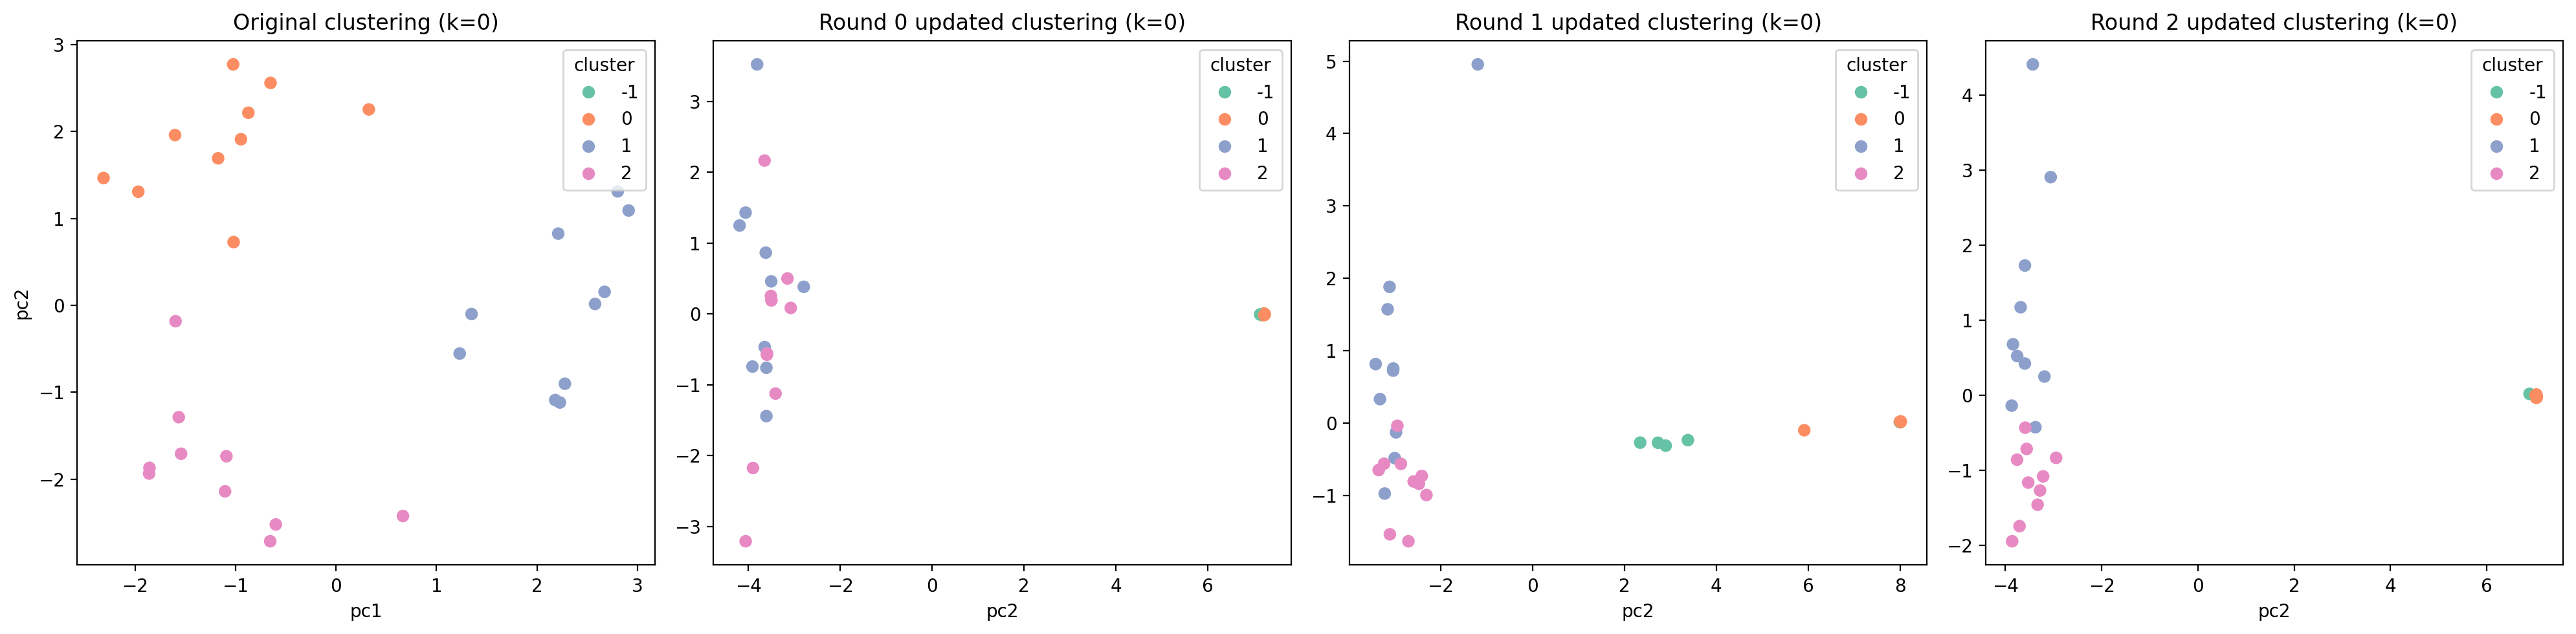

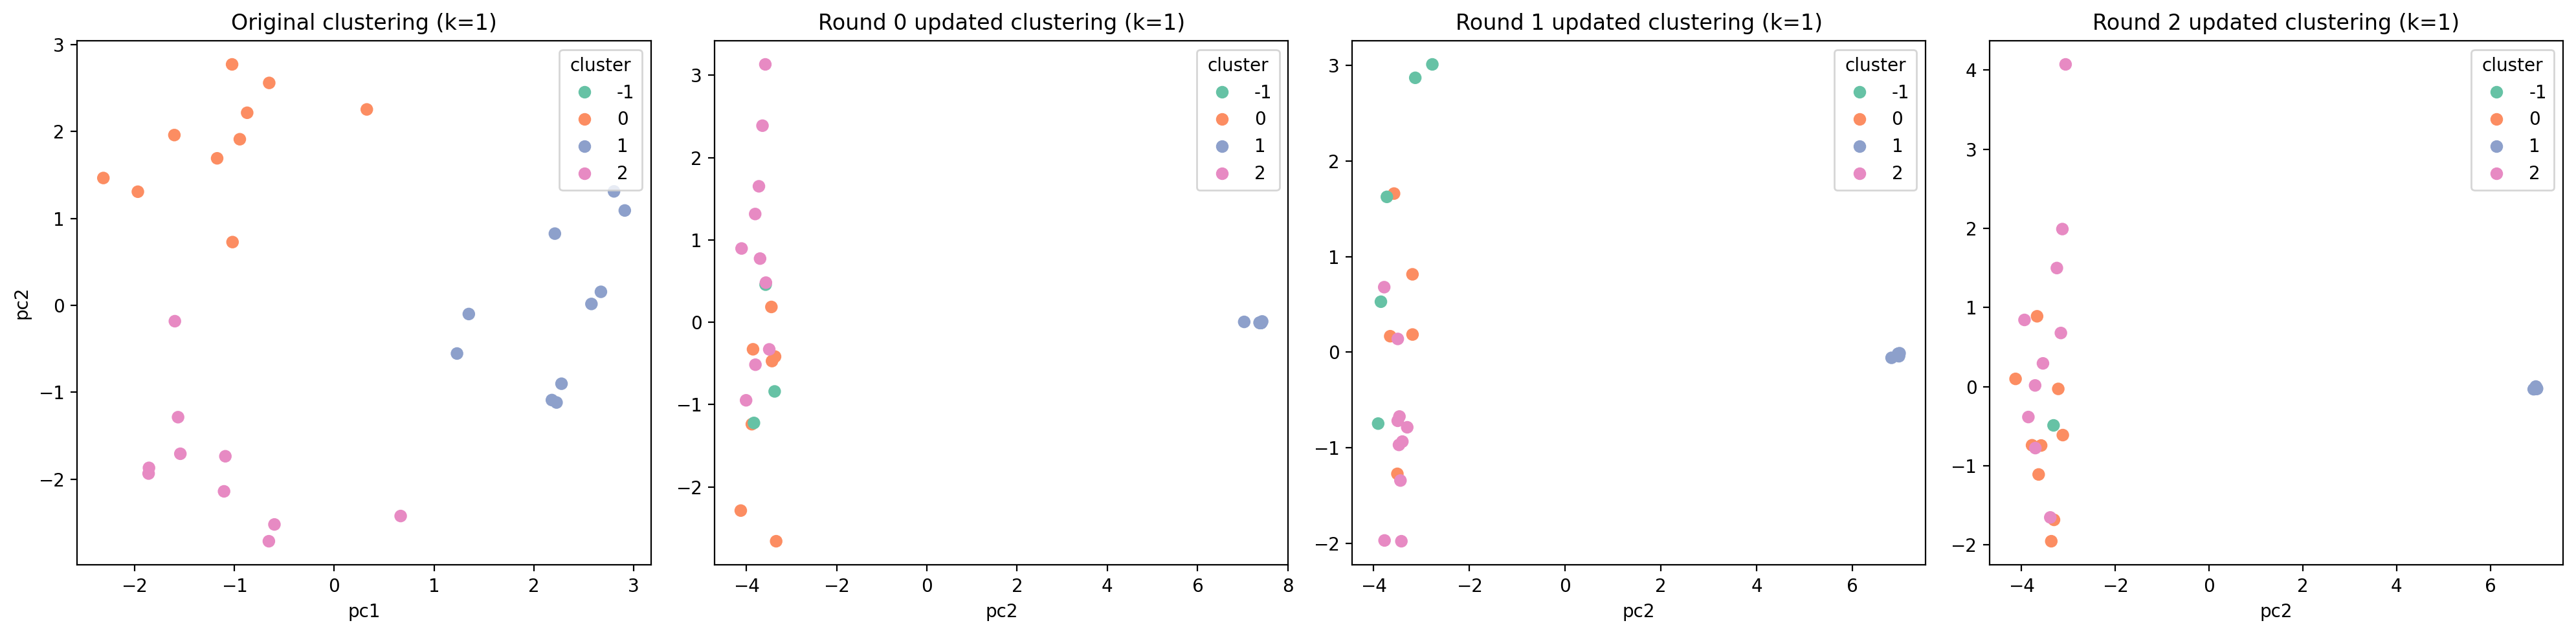

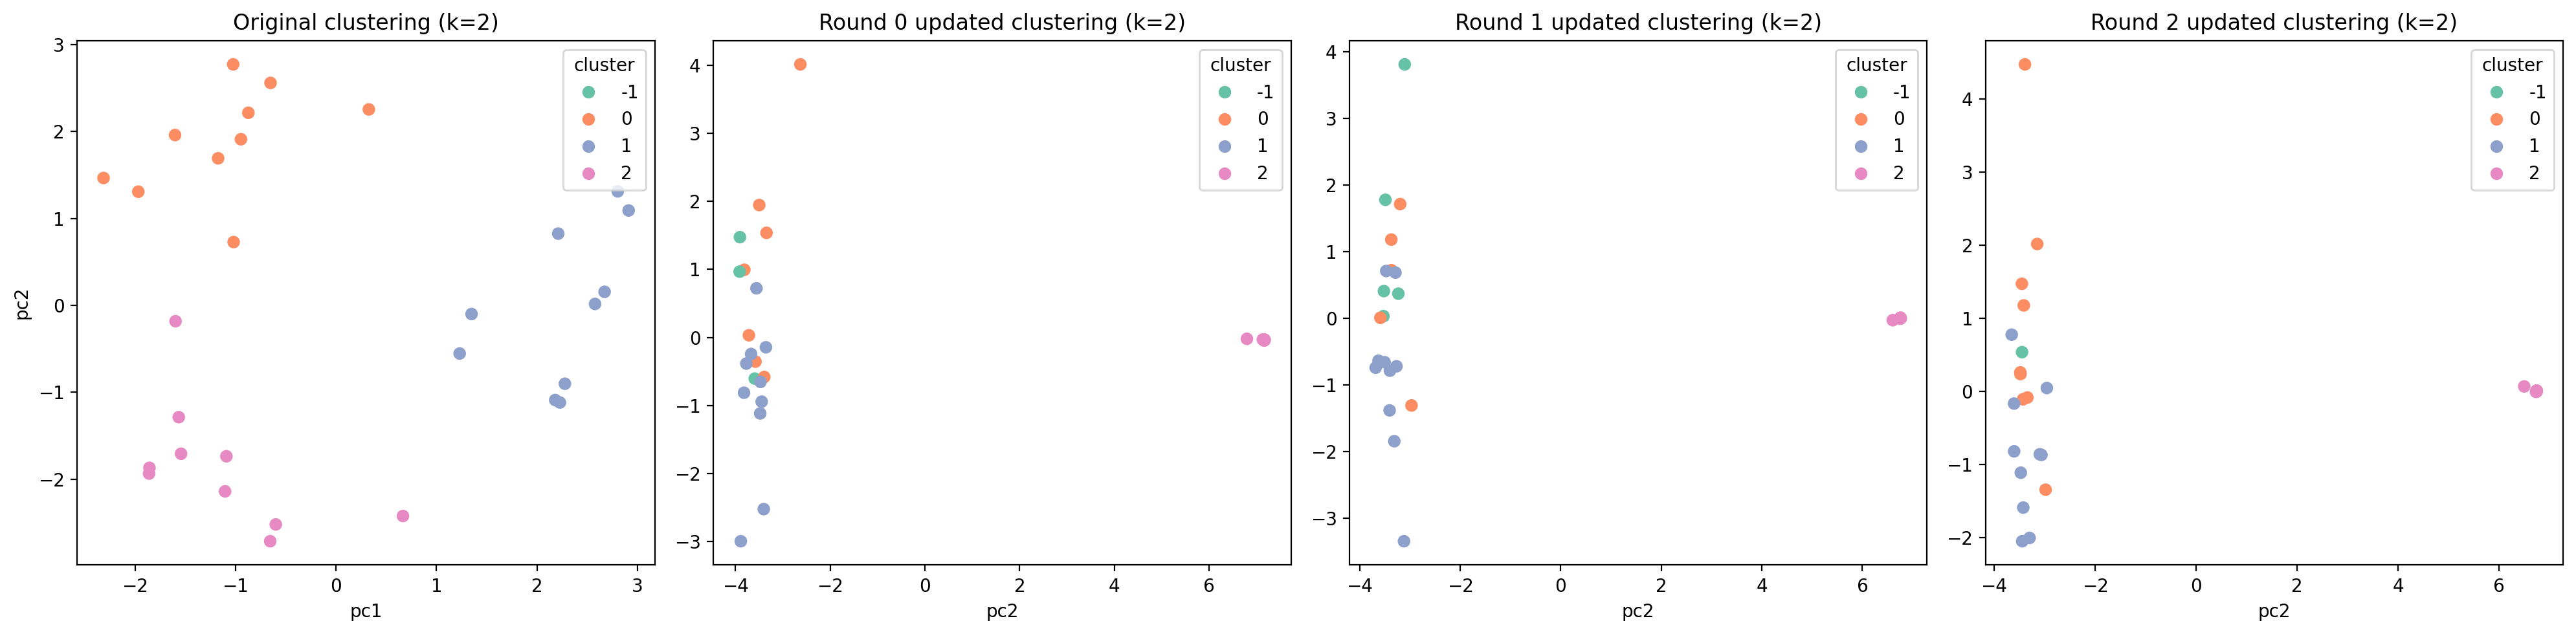

In [84]:
for k in range(K):
    plot_d_PCA_latent(d_data, d_latent_list, d_sens_hist, n_rounds, legend_title='cluster', k=k, 
                      plot_save_path=f'scripts_model/plots/simu2_3clusters_d_latent_k{k}.png')

In [ ]:
#print('round 1:')
#print('k = 0:')
#plot_training_losses(losses_train_hist_list[0][0], best_epoch_1round = best_epos_list[0][0])
#print('k = 1:')
#plot_training_losses(losses_train_hist_list[0][1], best_epoch_1round = best_epos_list[0][1])

# print('round 1:')
# print('k = 0:')
# print('trainning set:')
# plot_training_losses(losses_train_hist_list[0][0], best_epoch_1round = best_epos_list[0][0], train_hist = True, test_hist = False)
# print('testing set:')
# plot_training_losses(losses_train_hist_list[0][0], best_epoch_1round = best_epos_list[0][0], train_hist = False, test_hist = True)

k = 0:
round 0:


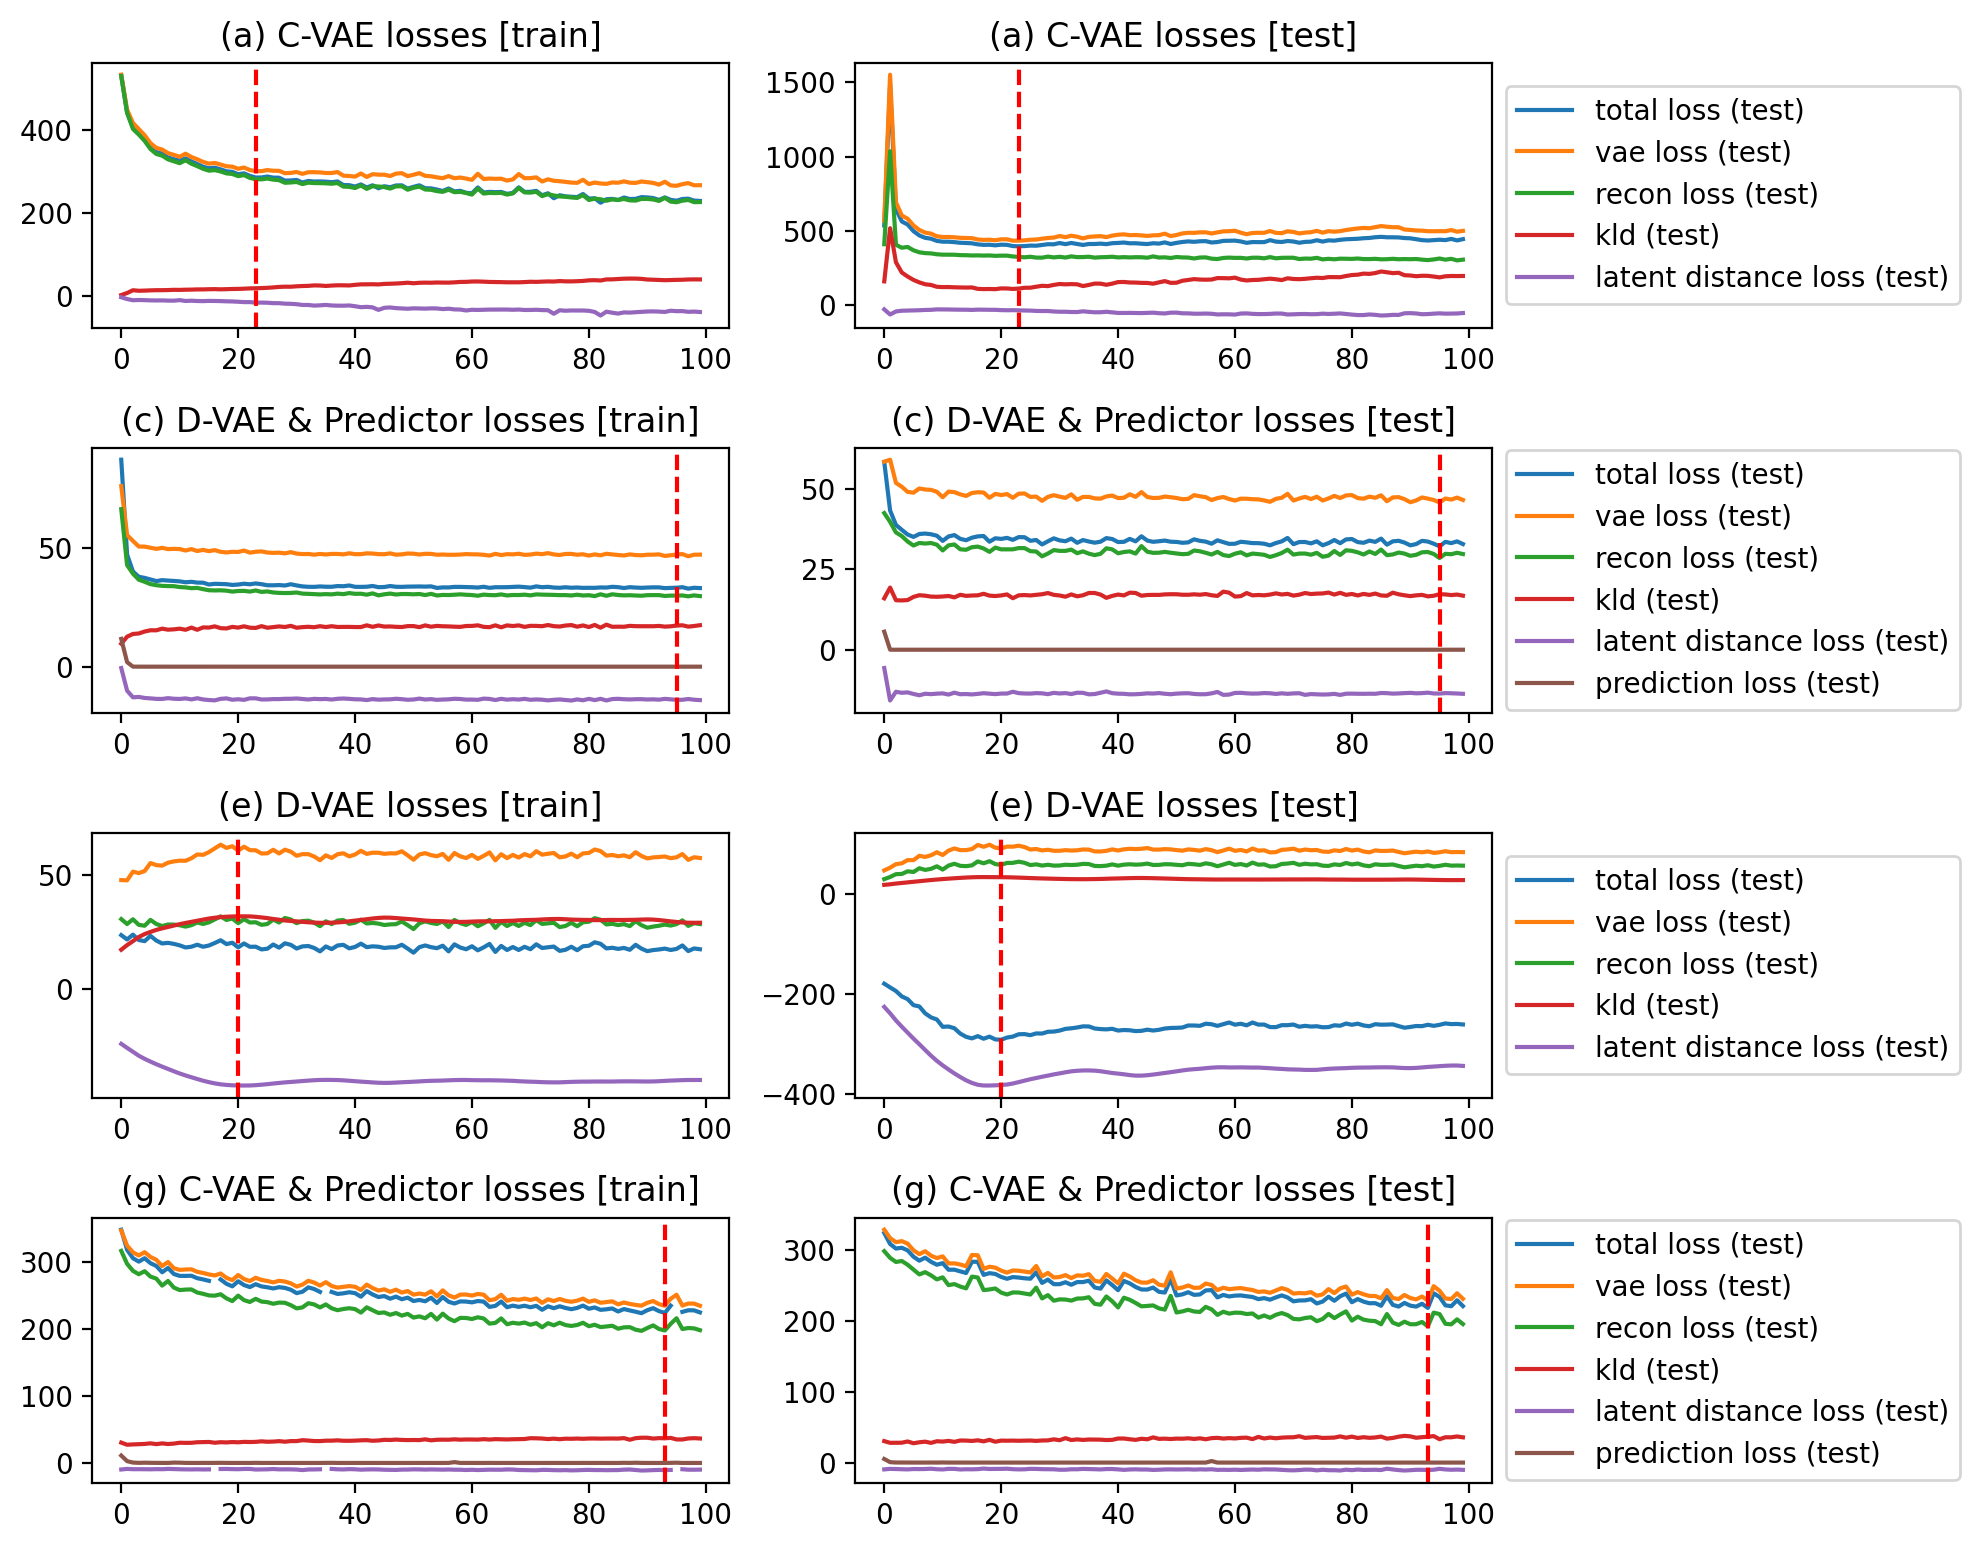

round 1:


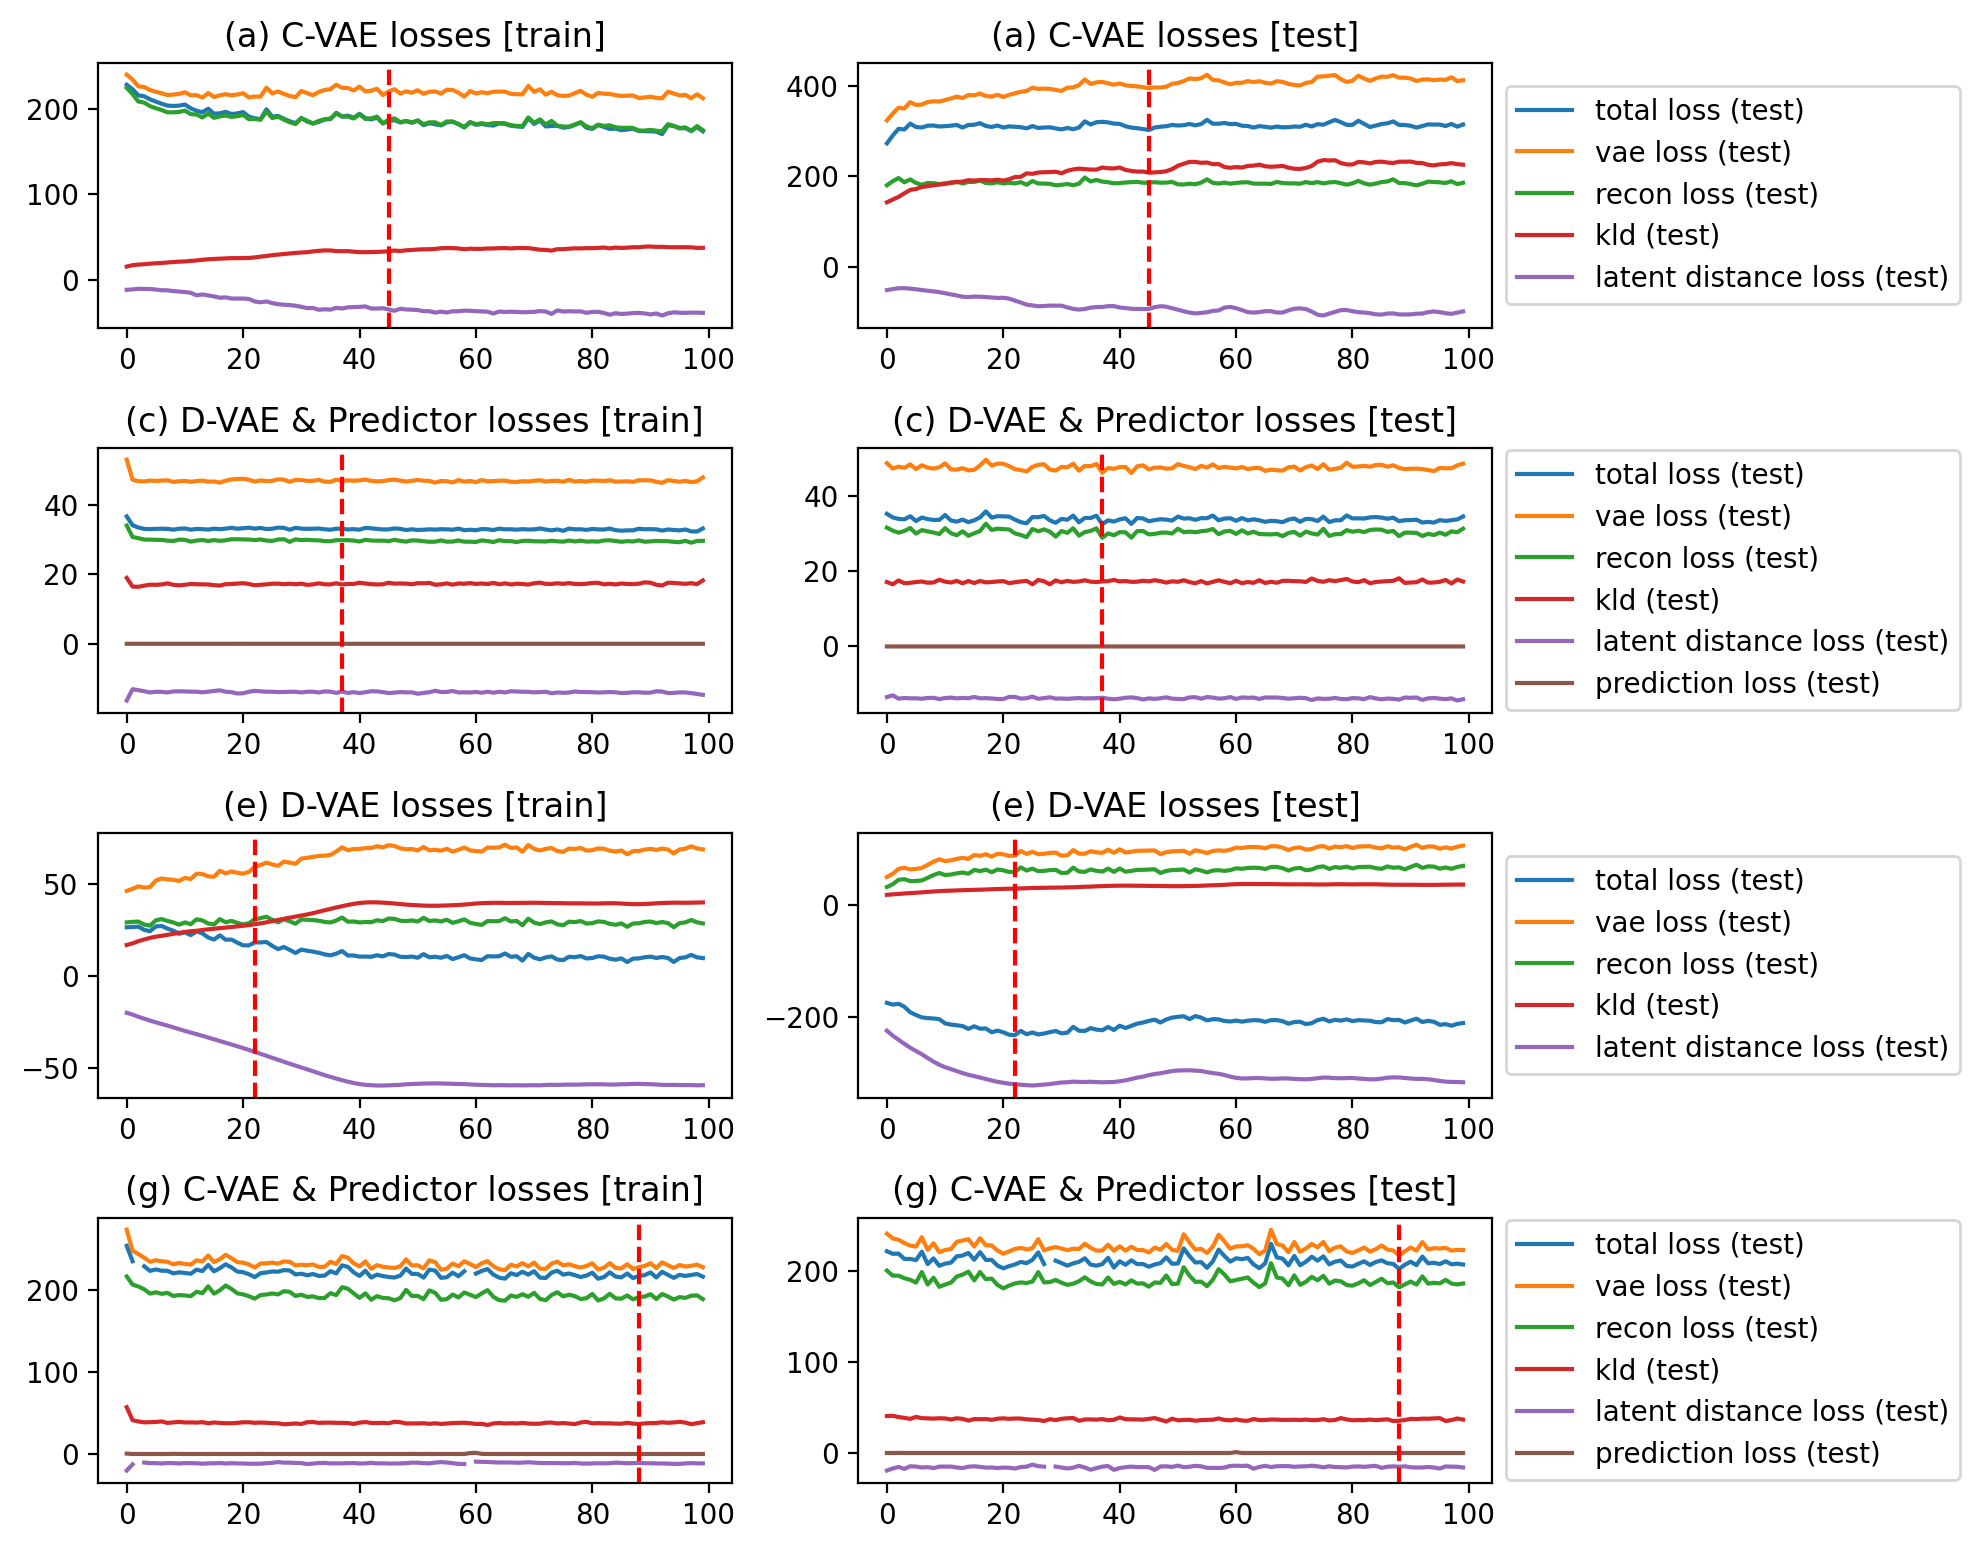

round 2:


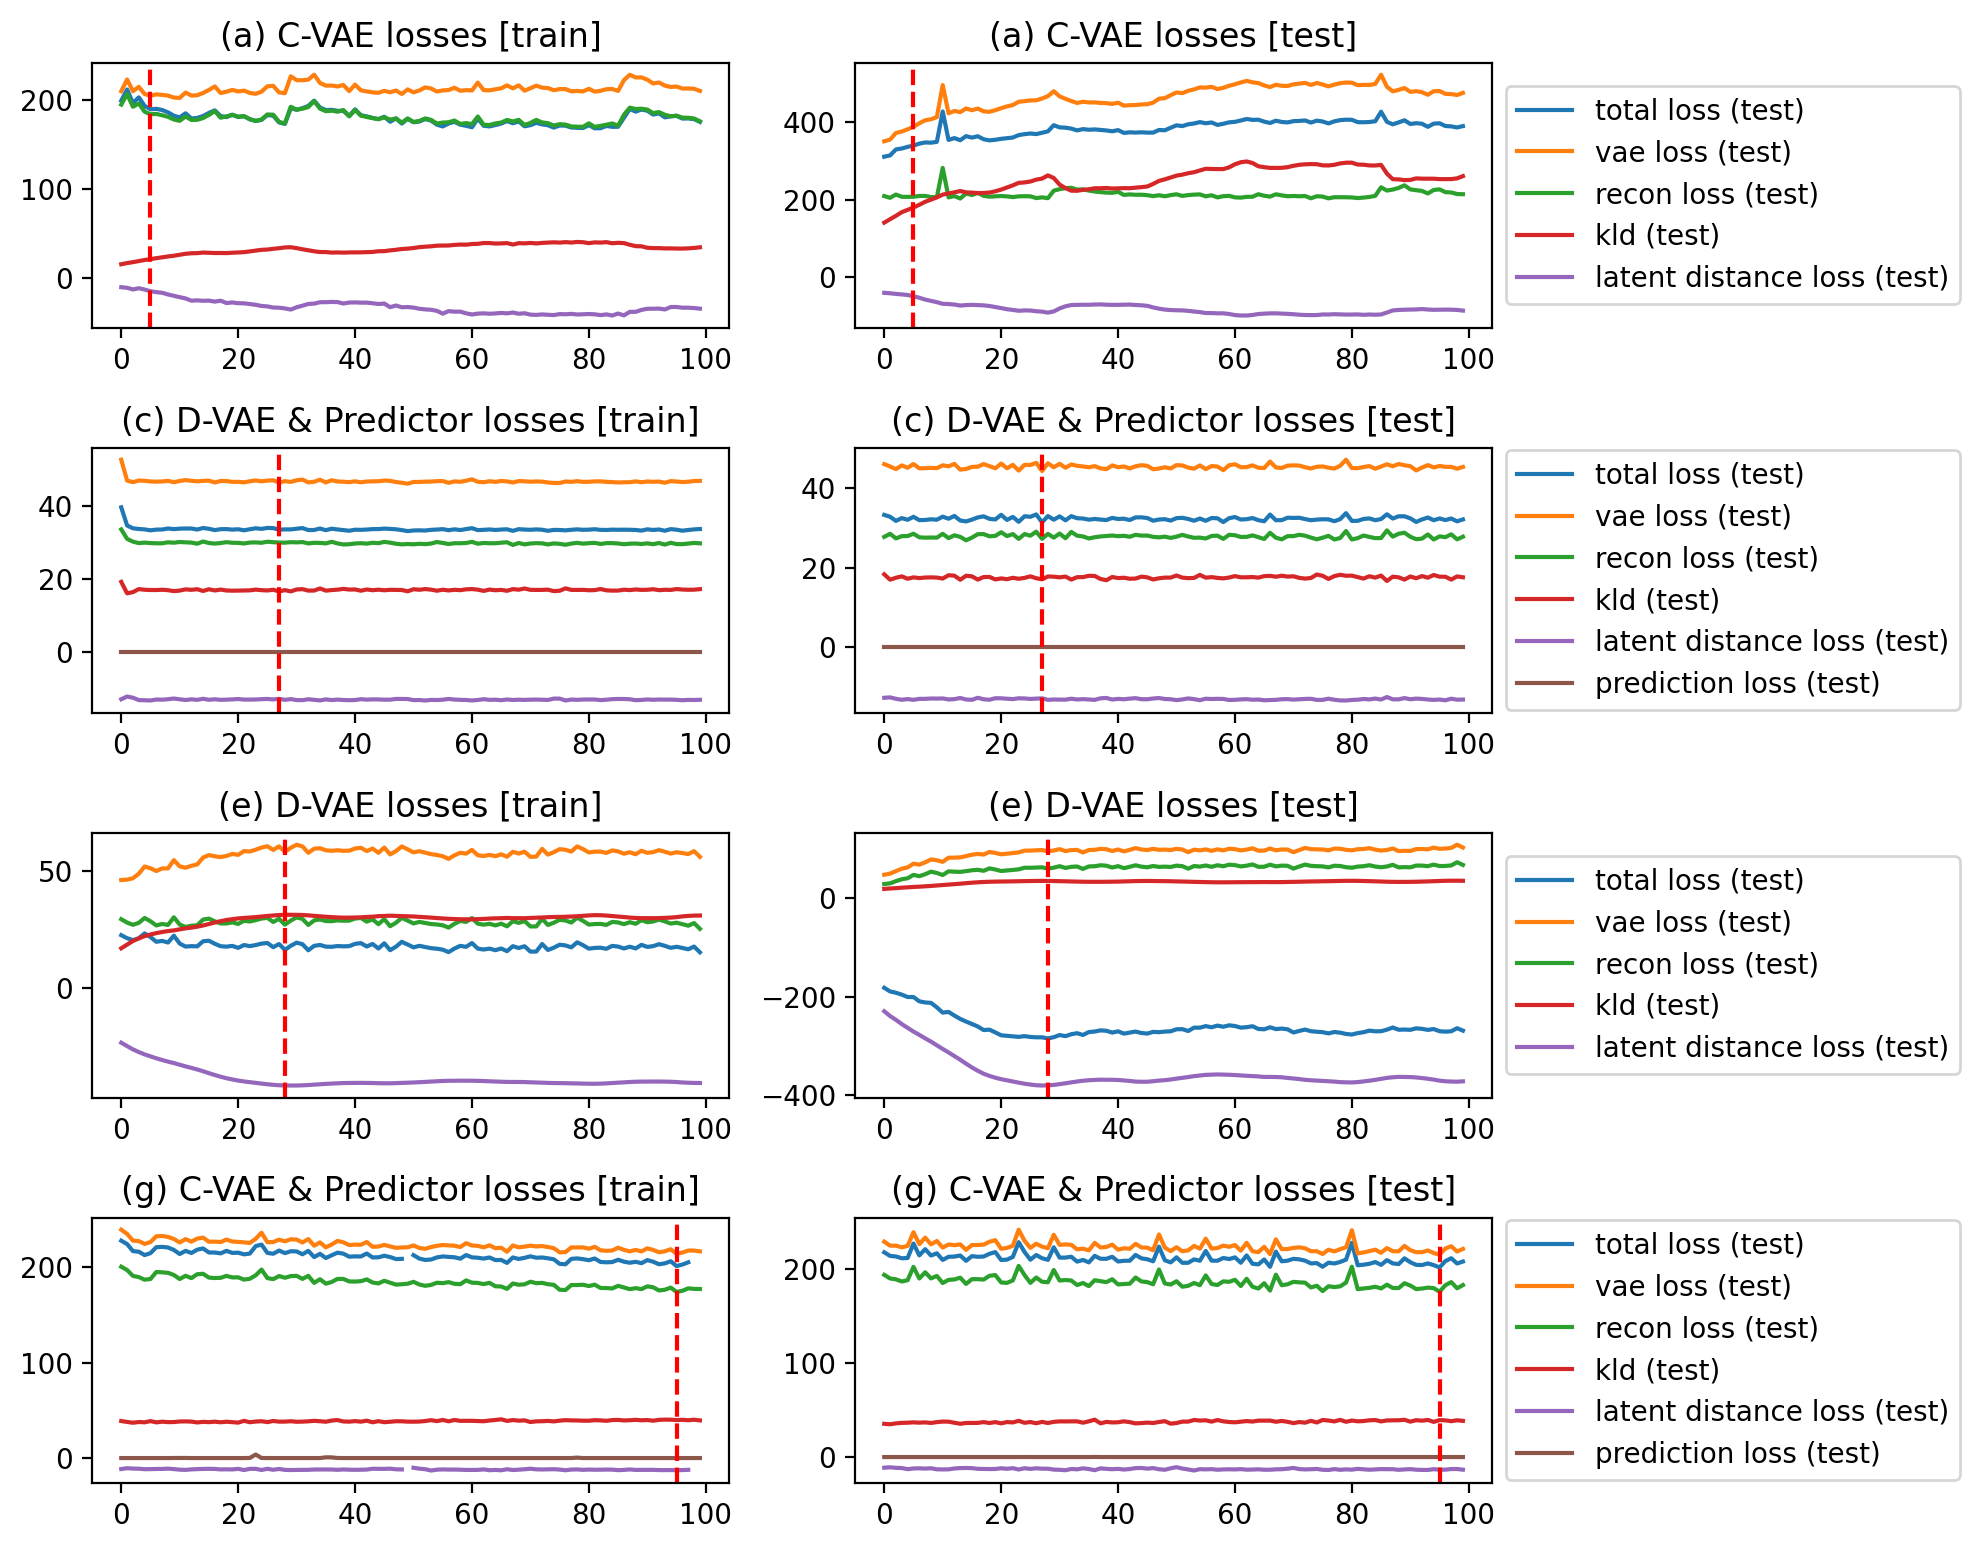

k = 1:
round 0:


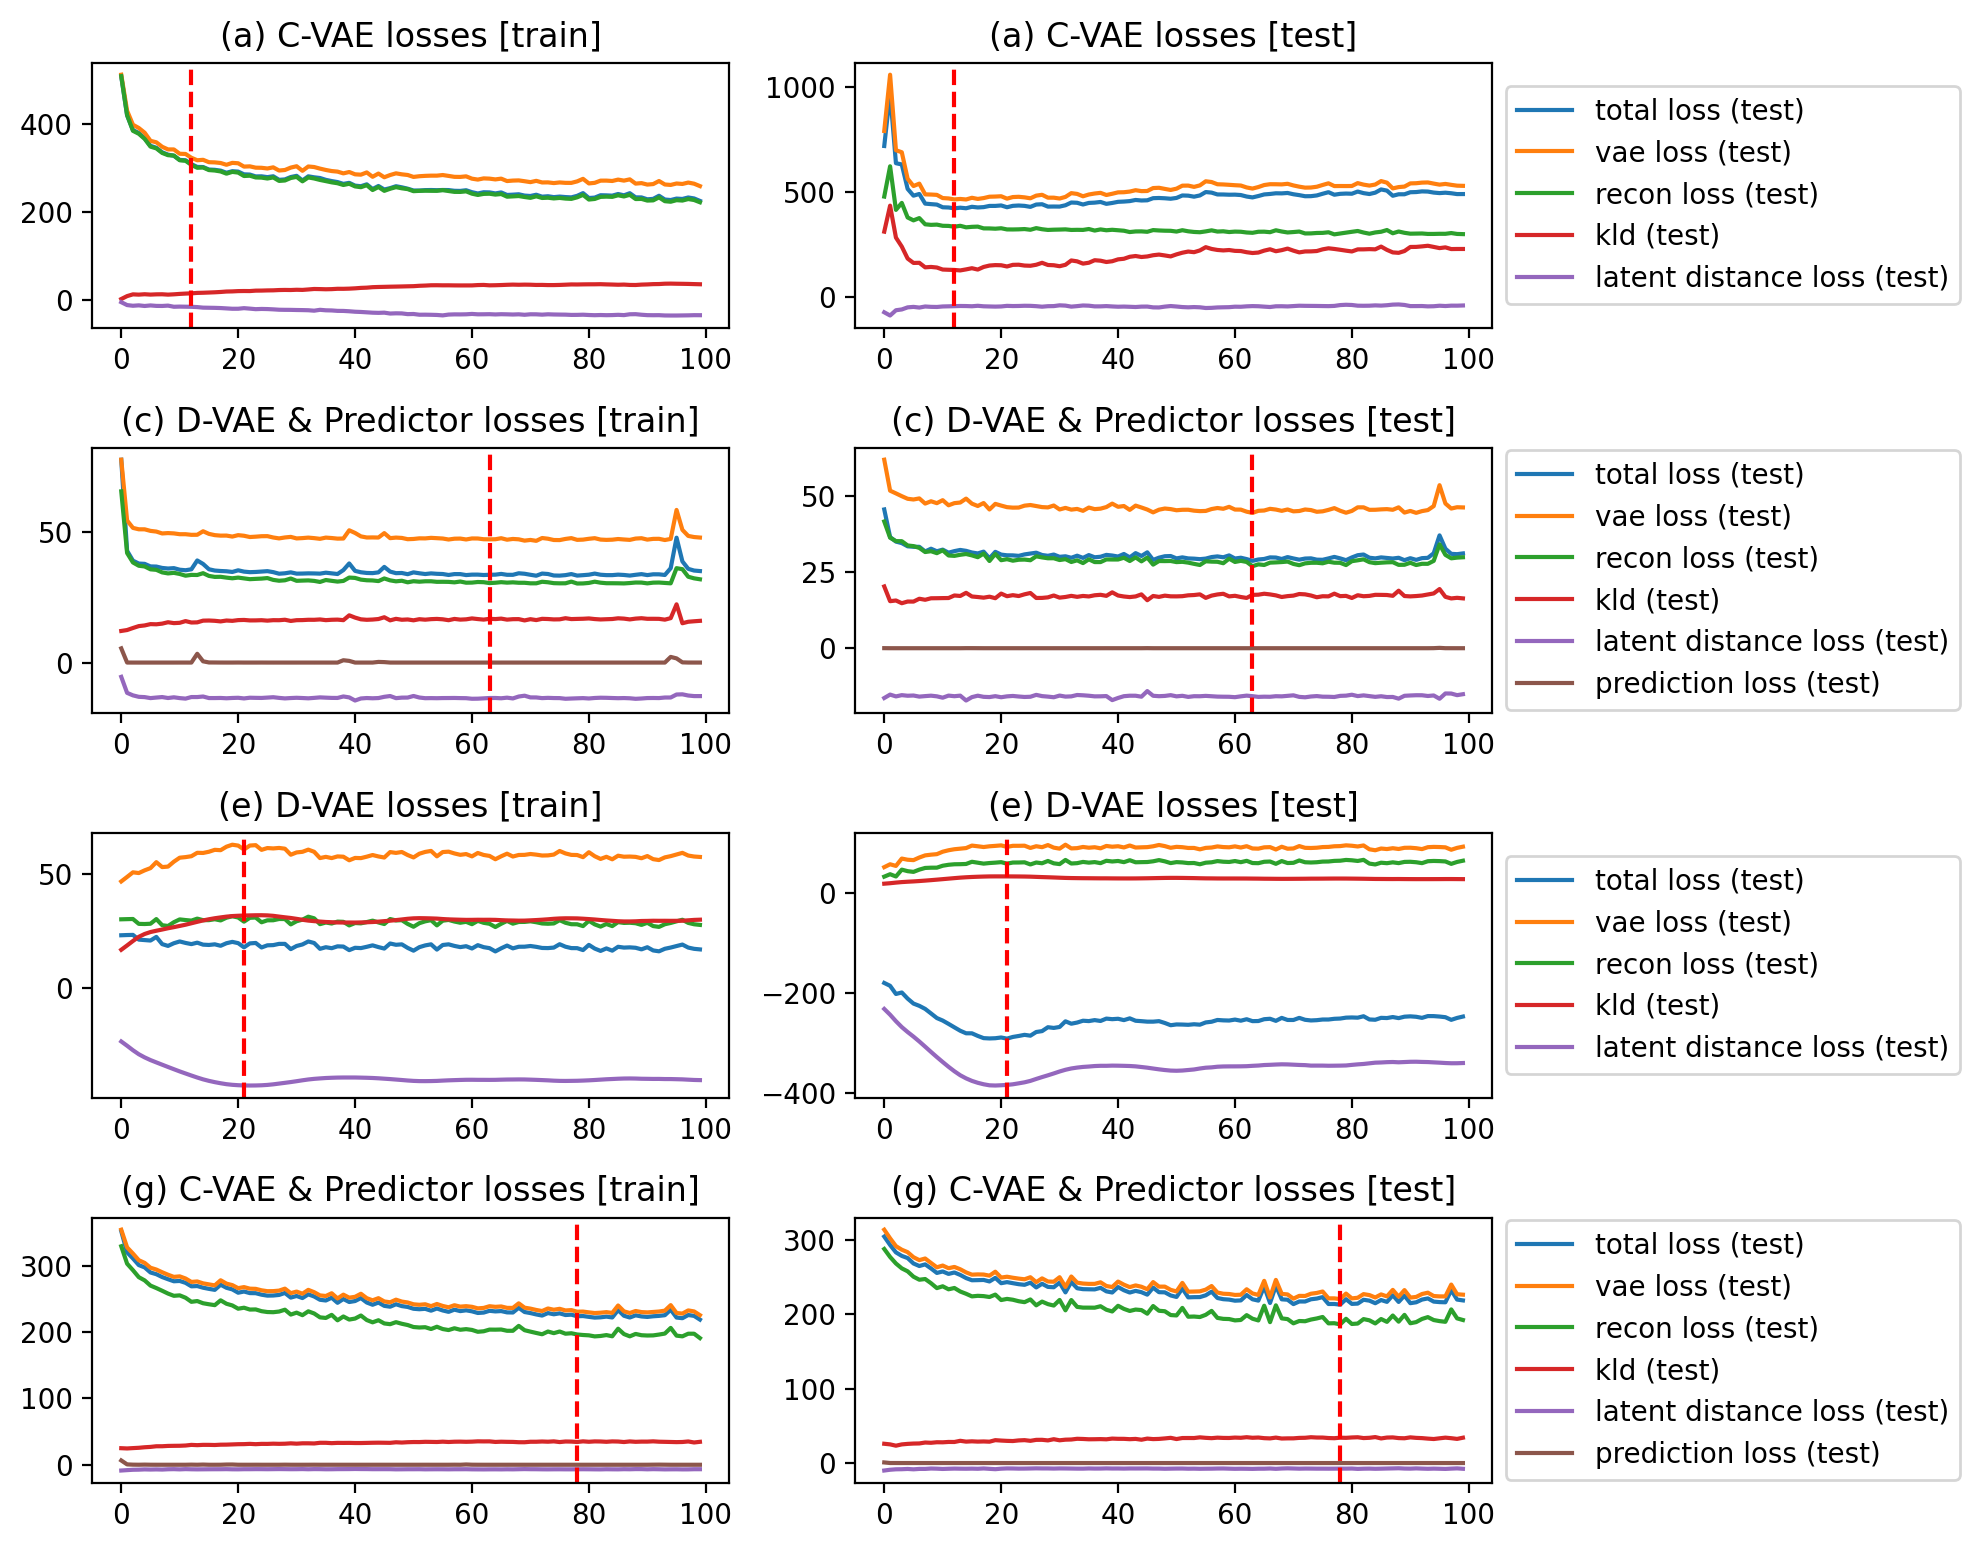

round 1:


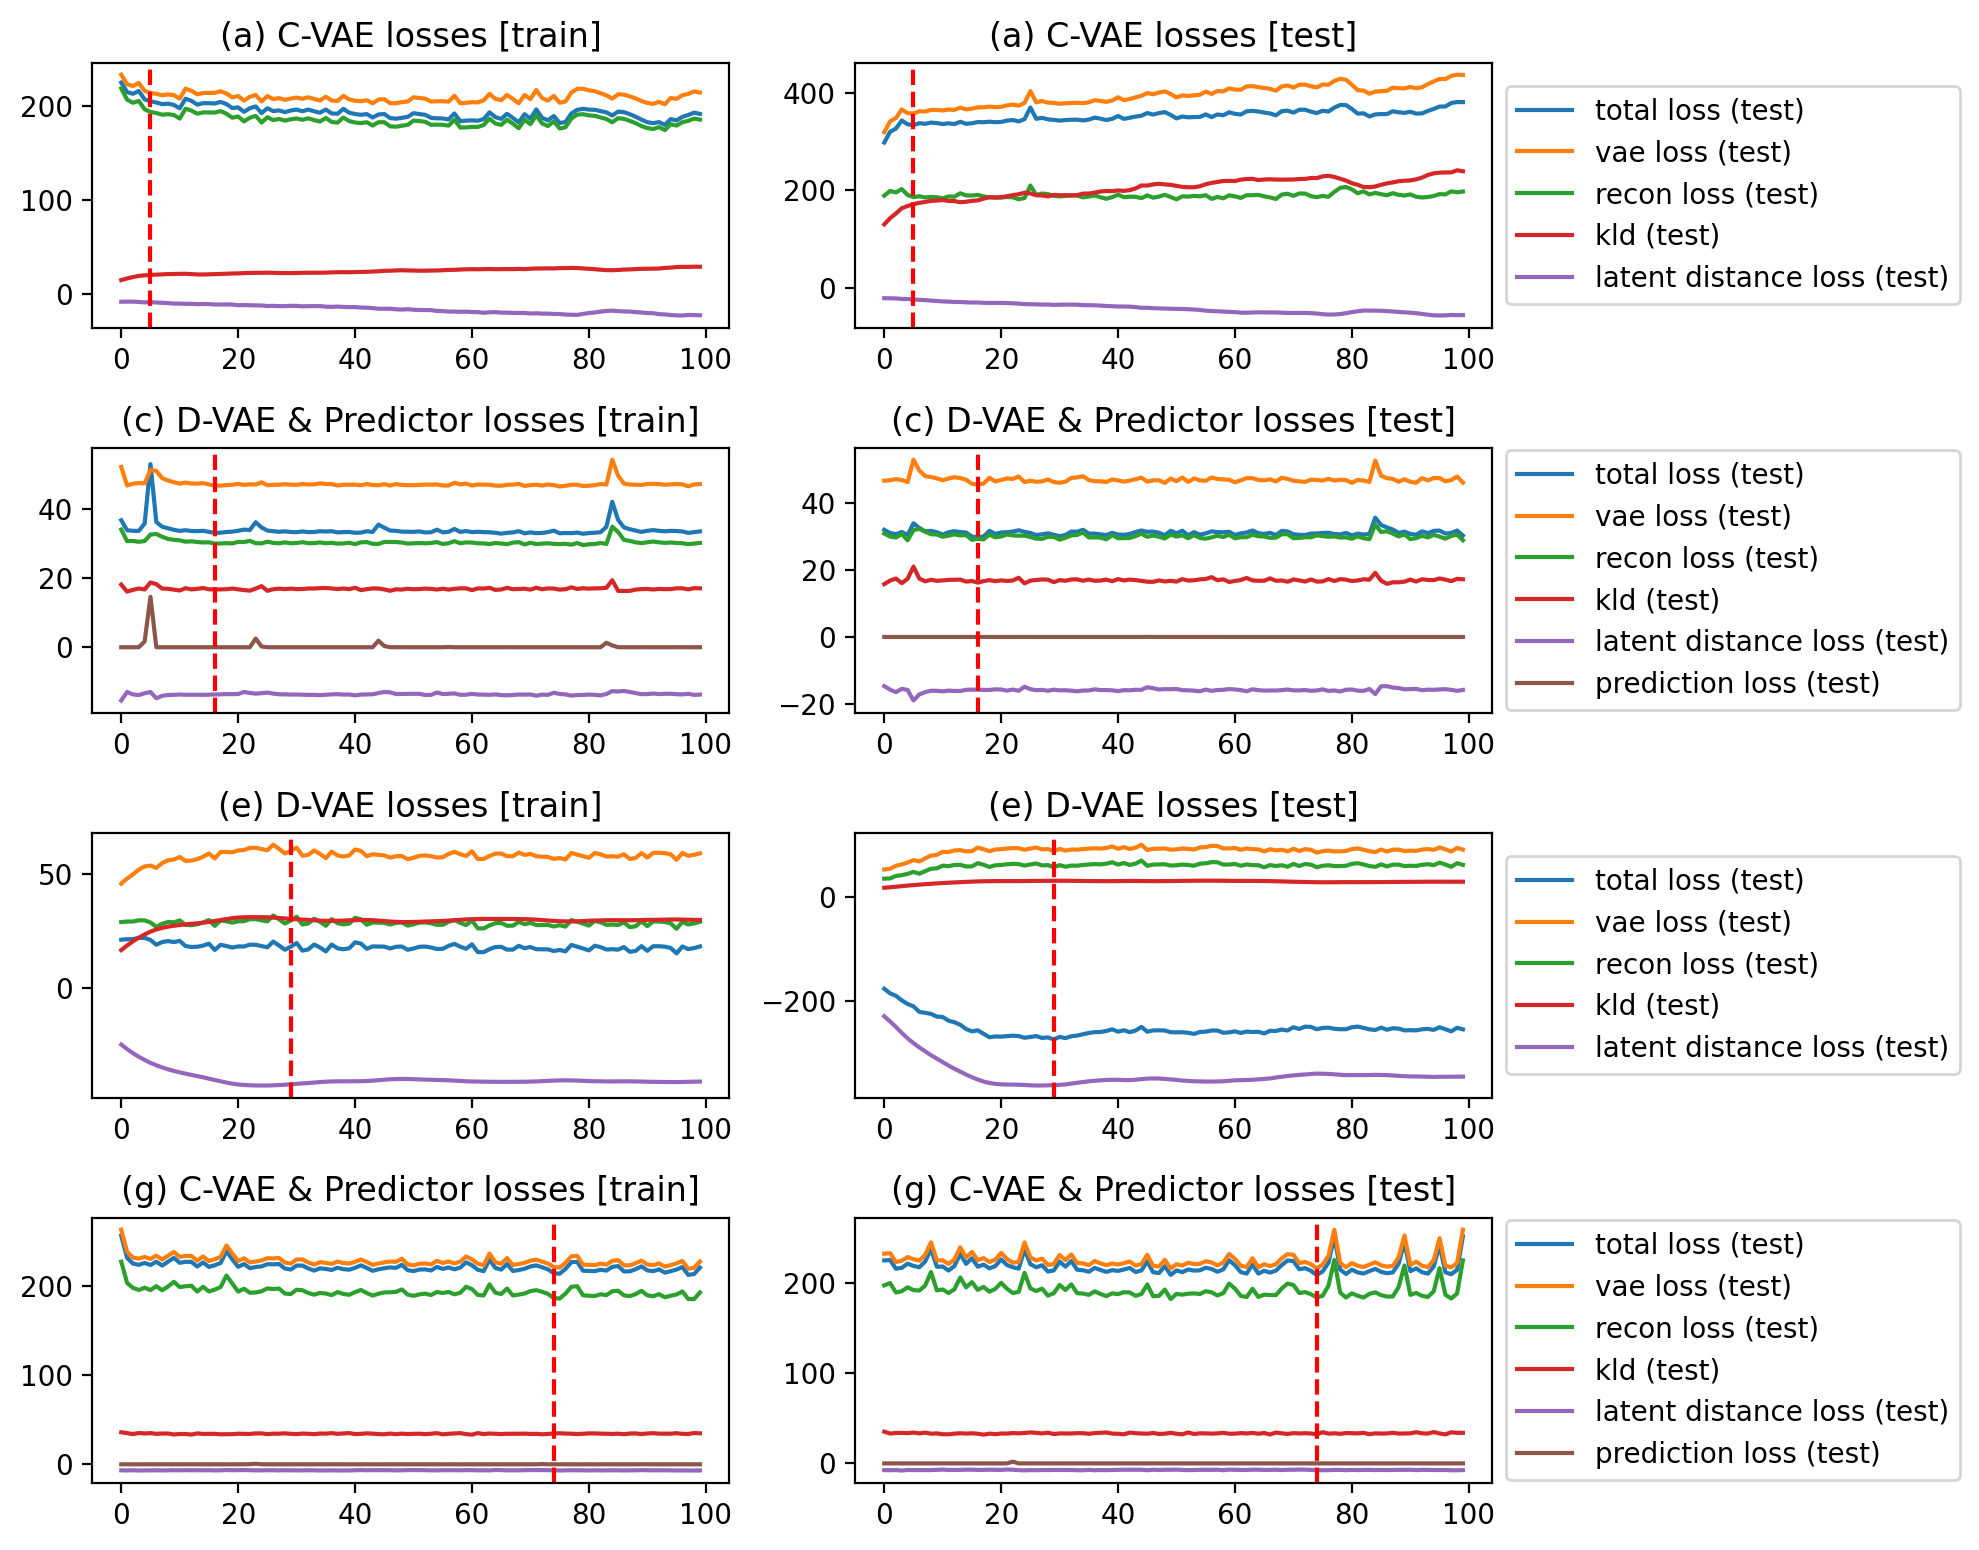

round 2:


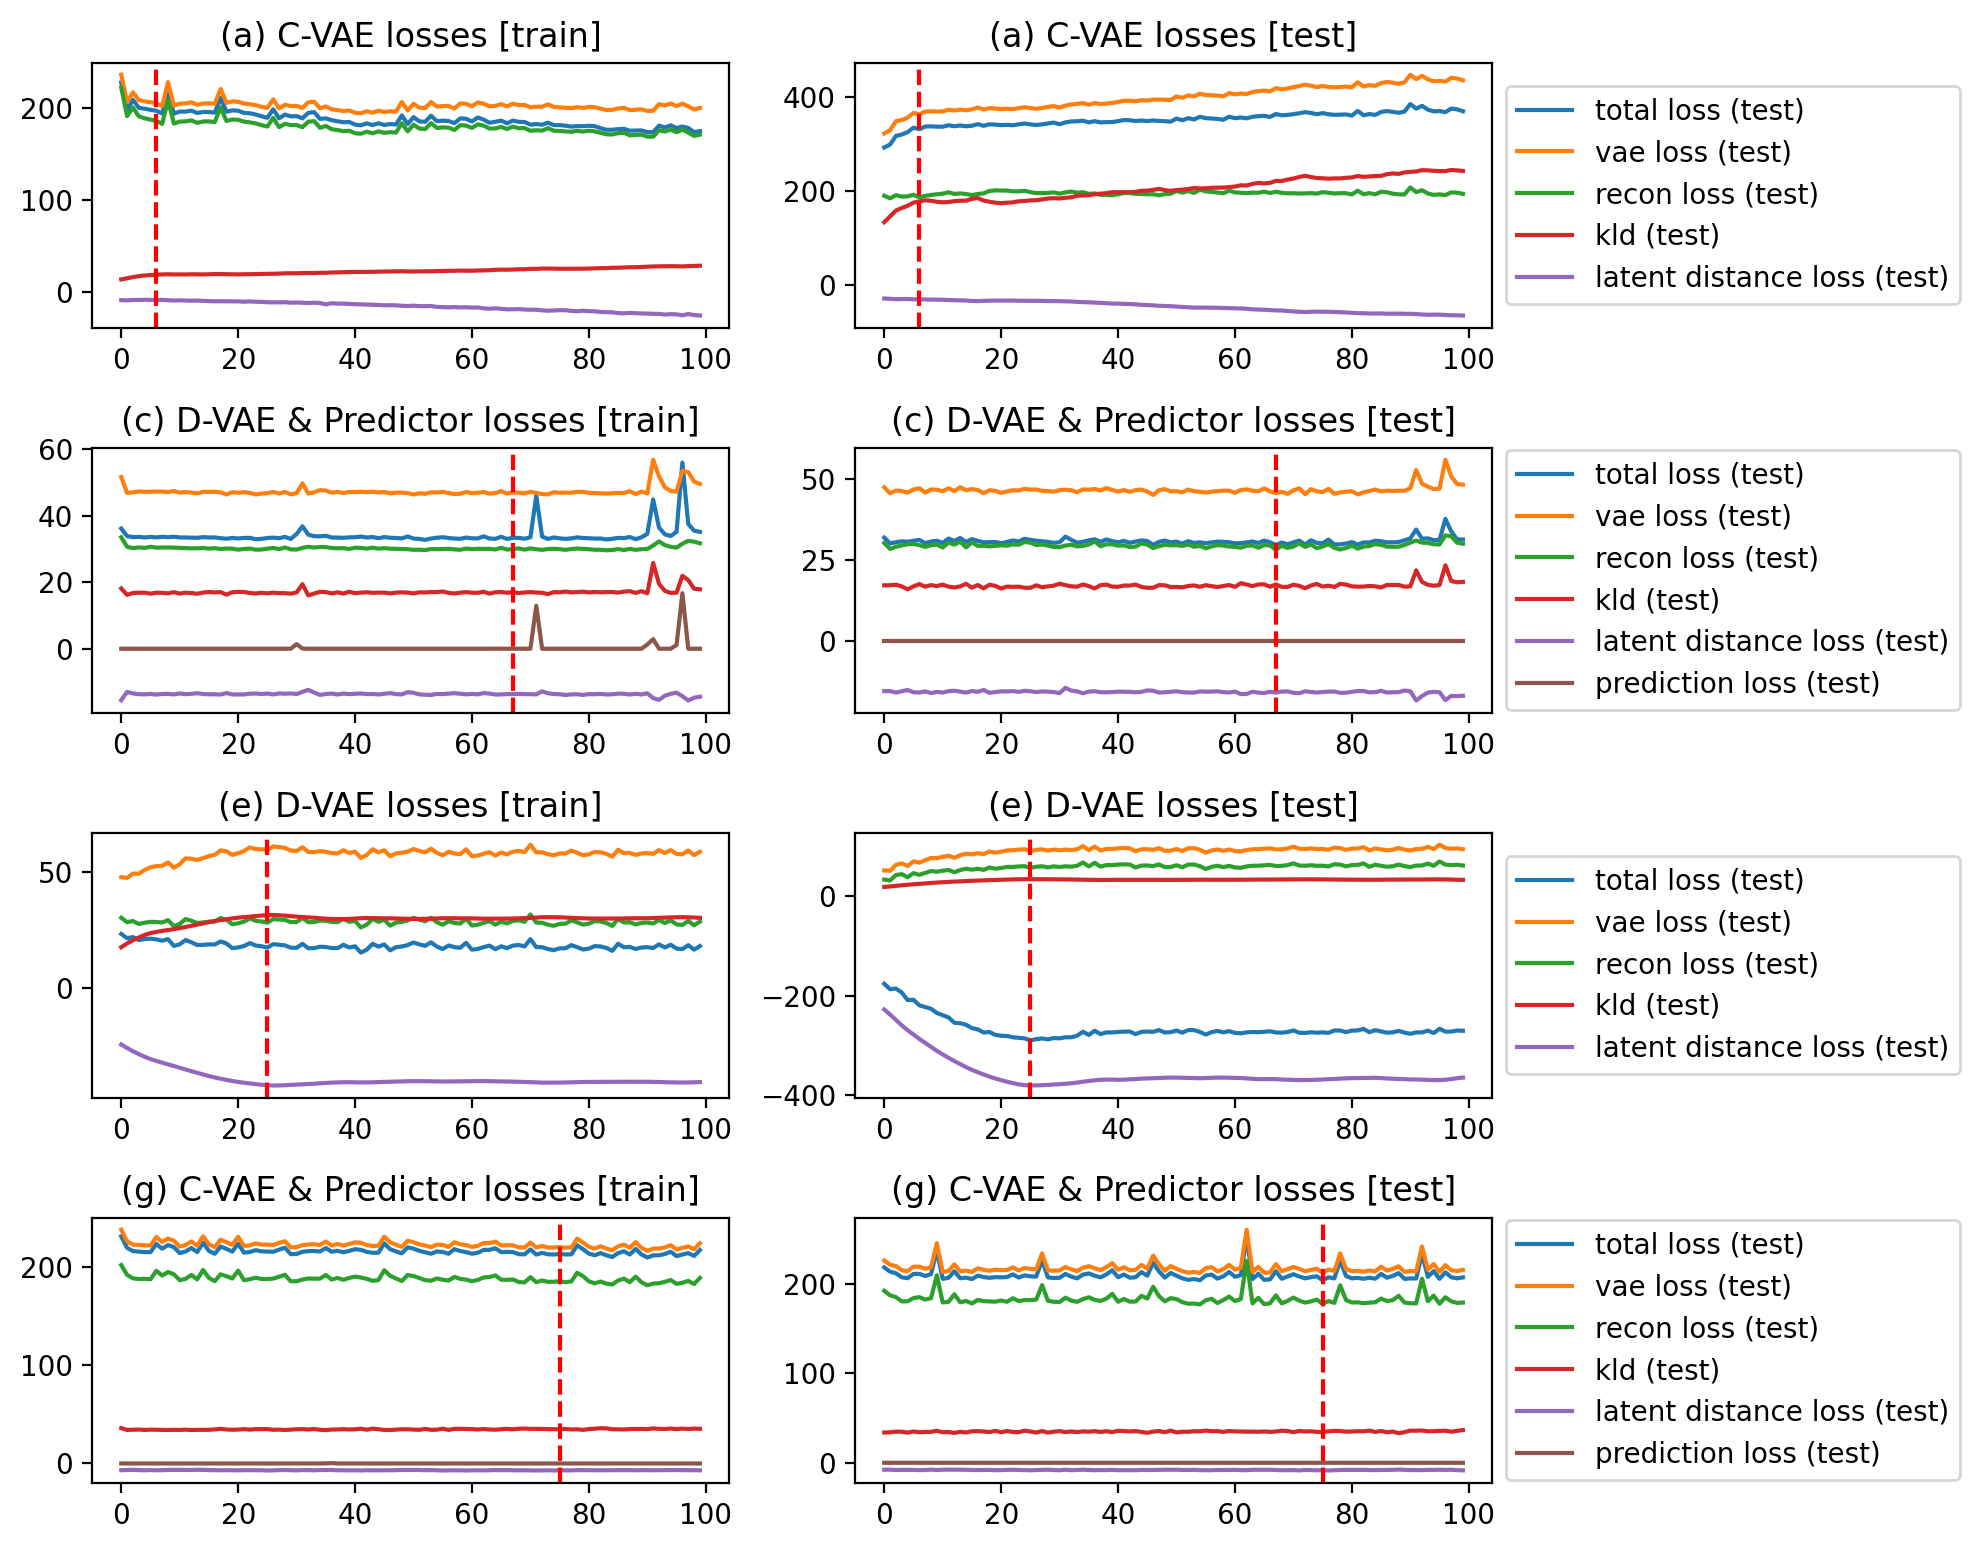

k = 2:
round 0:


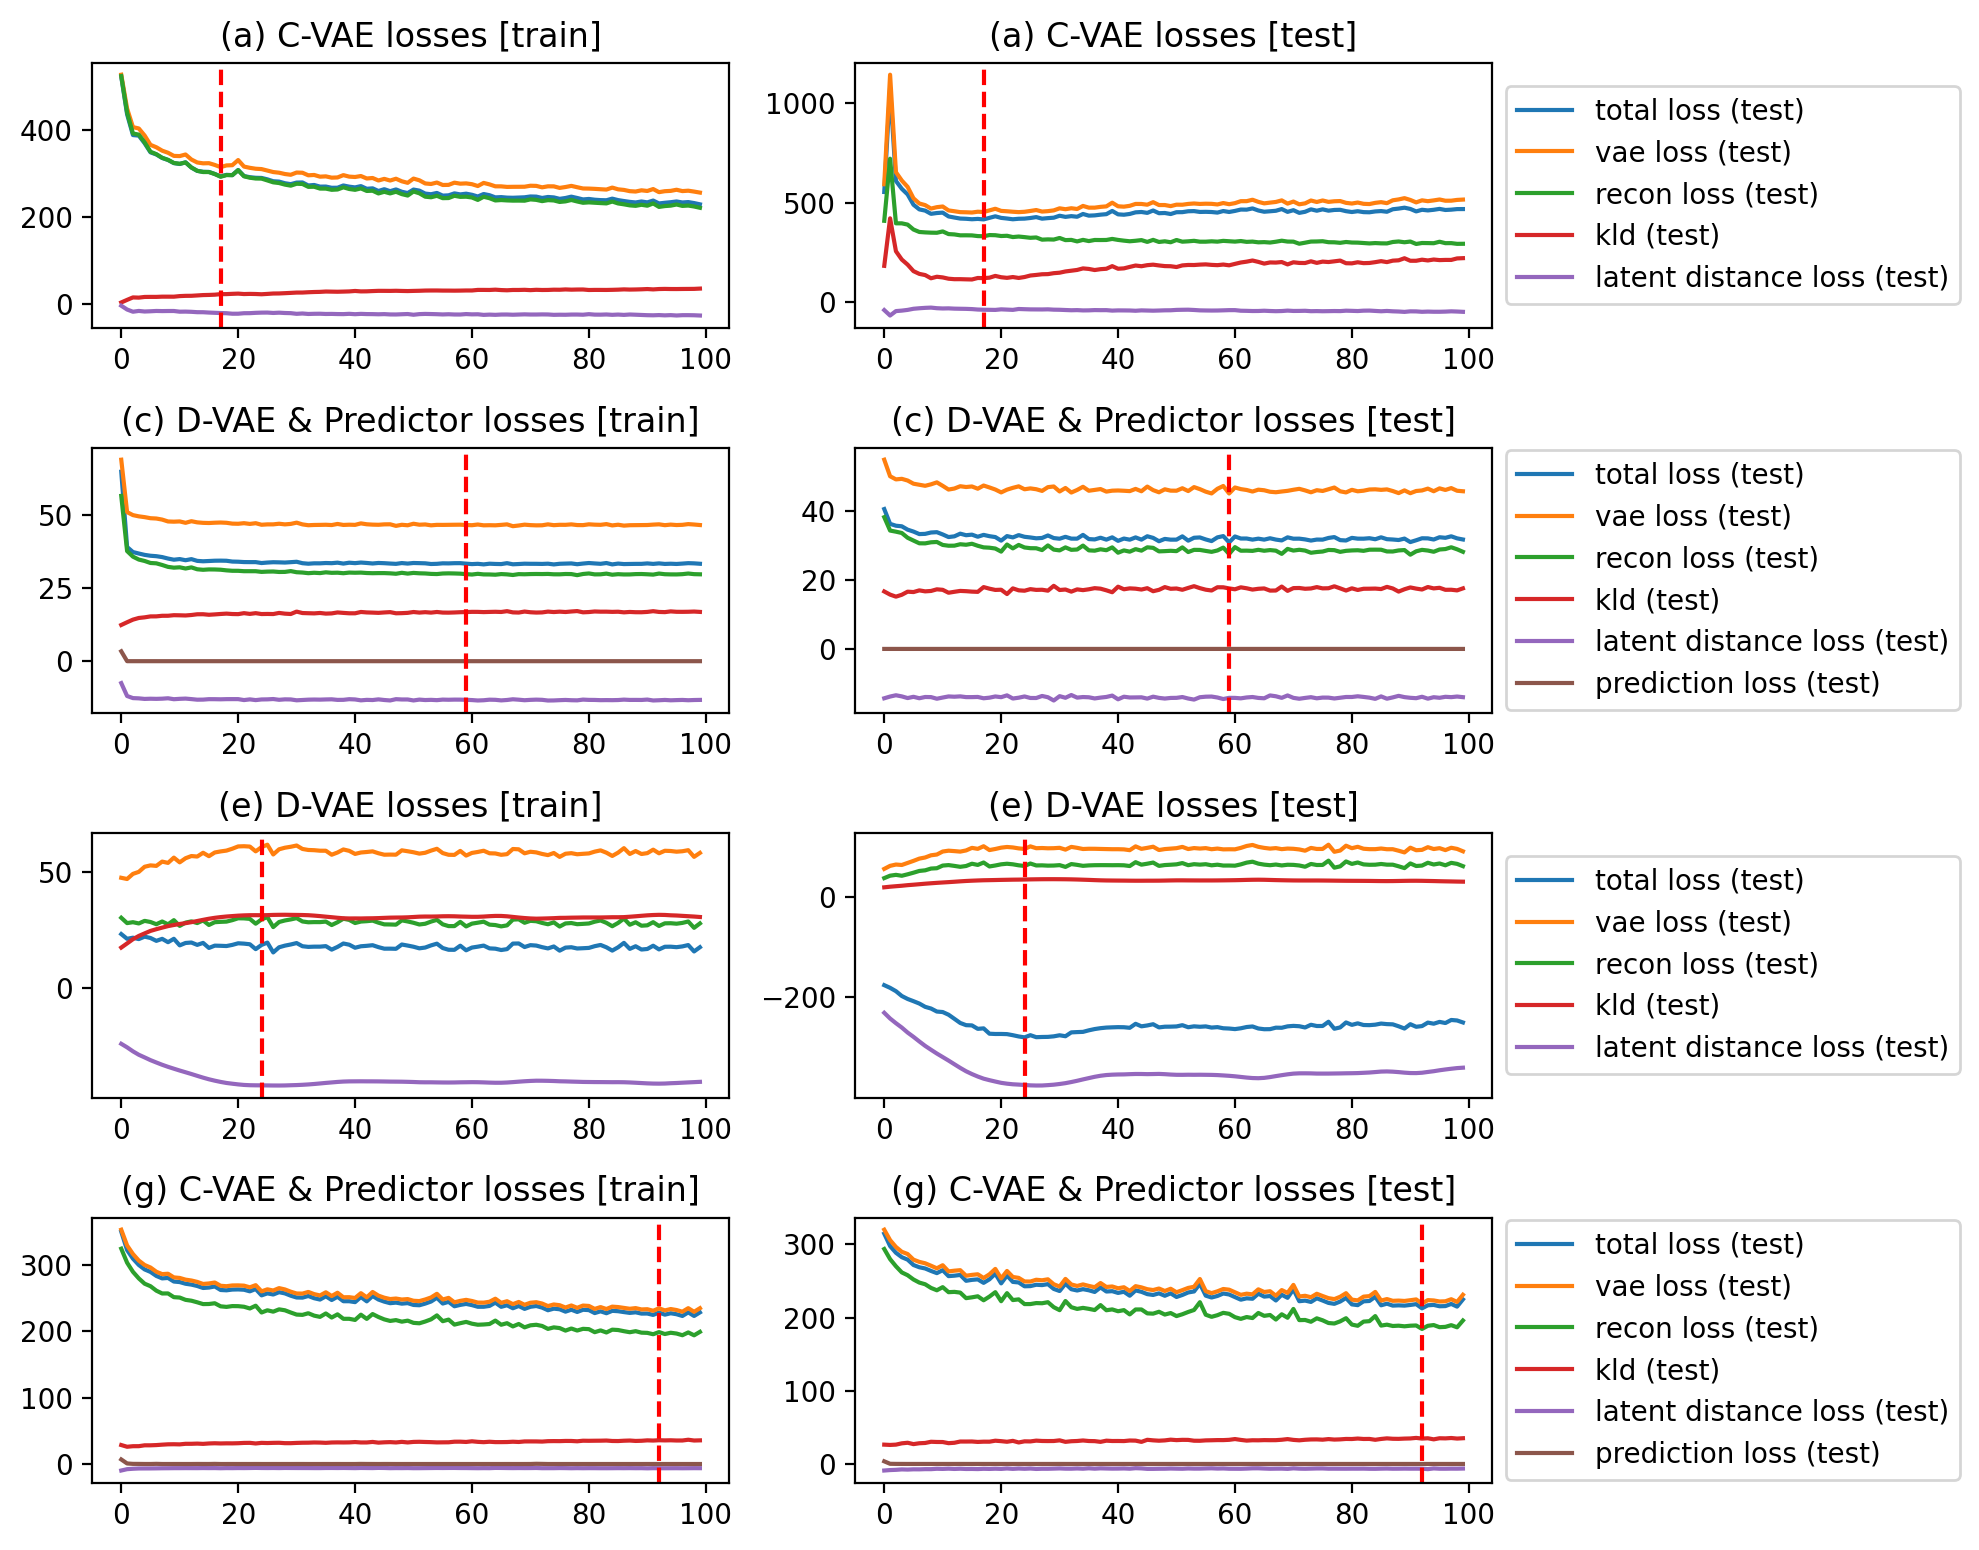

round 1:


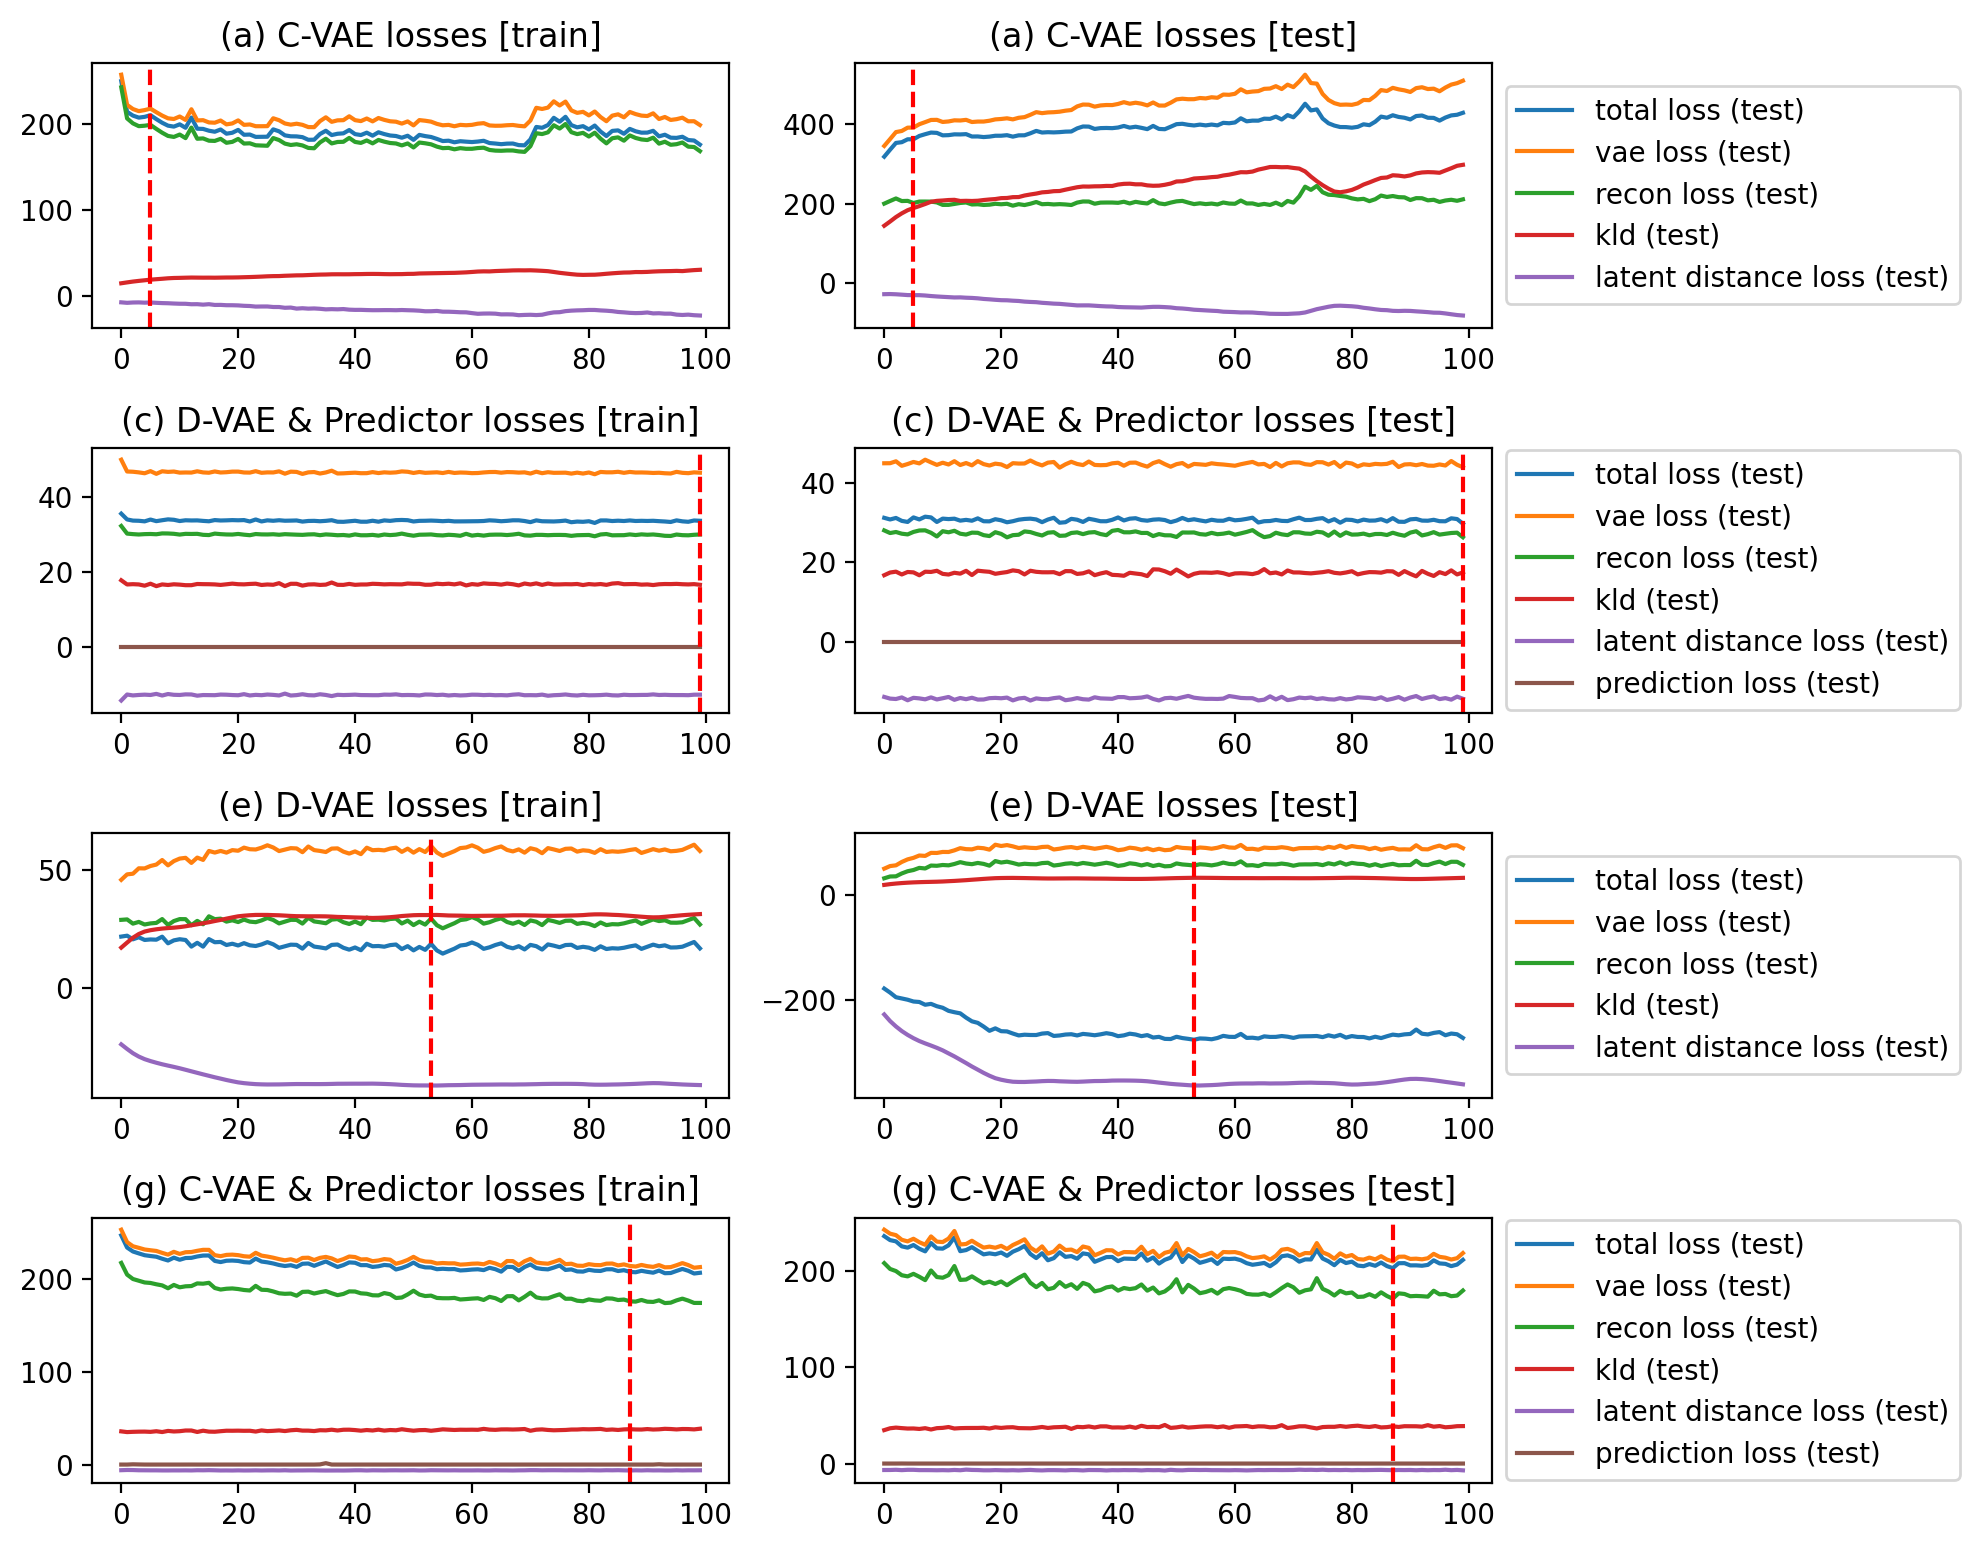

round 2:


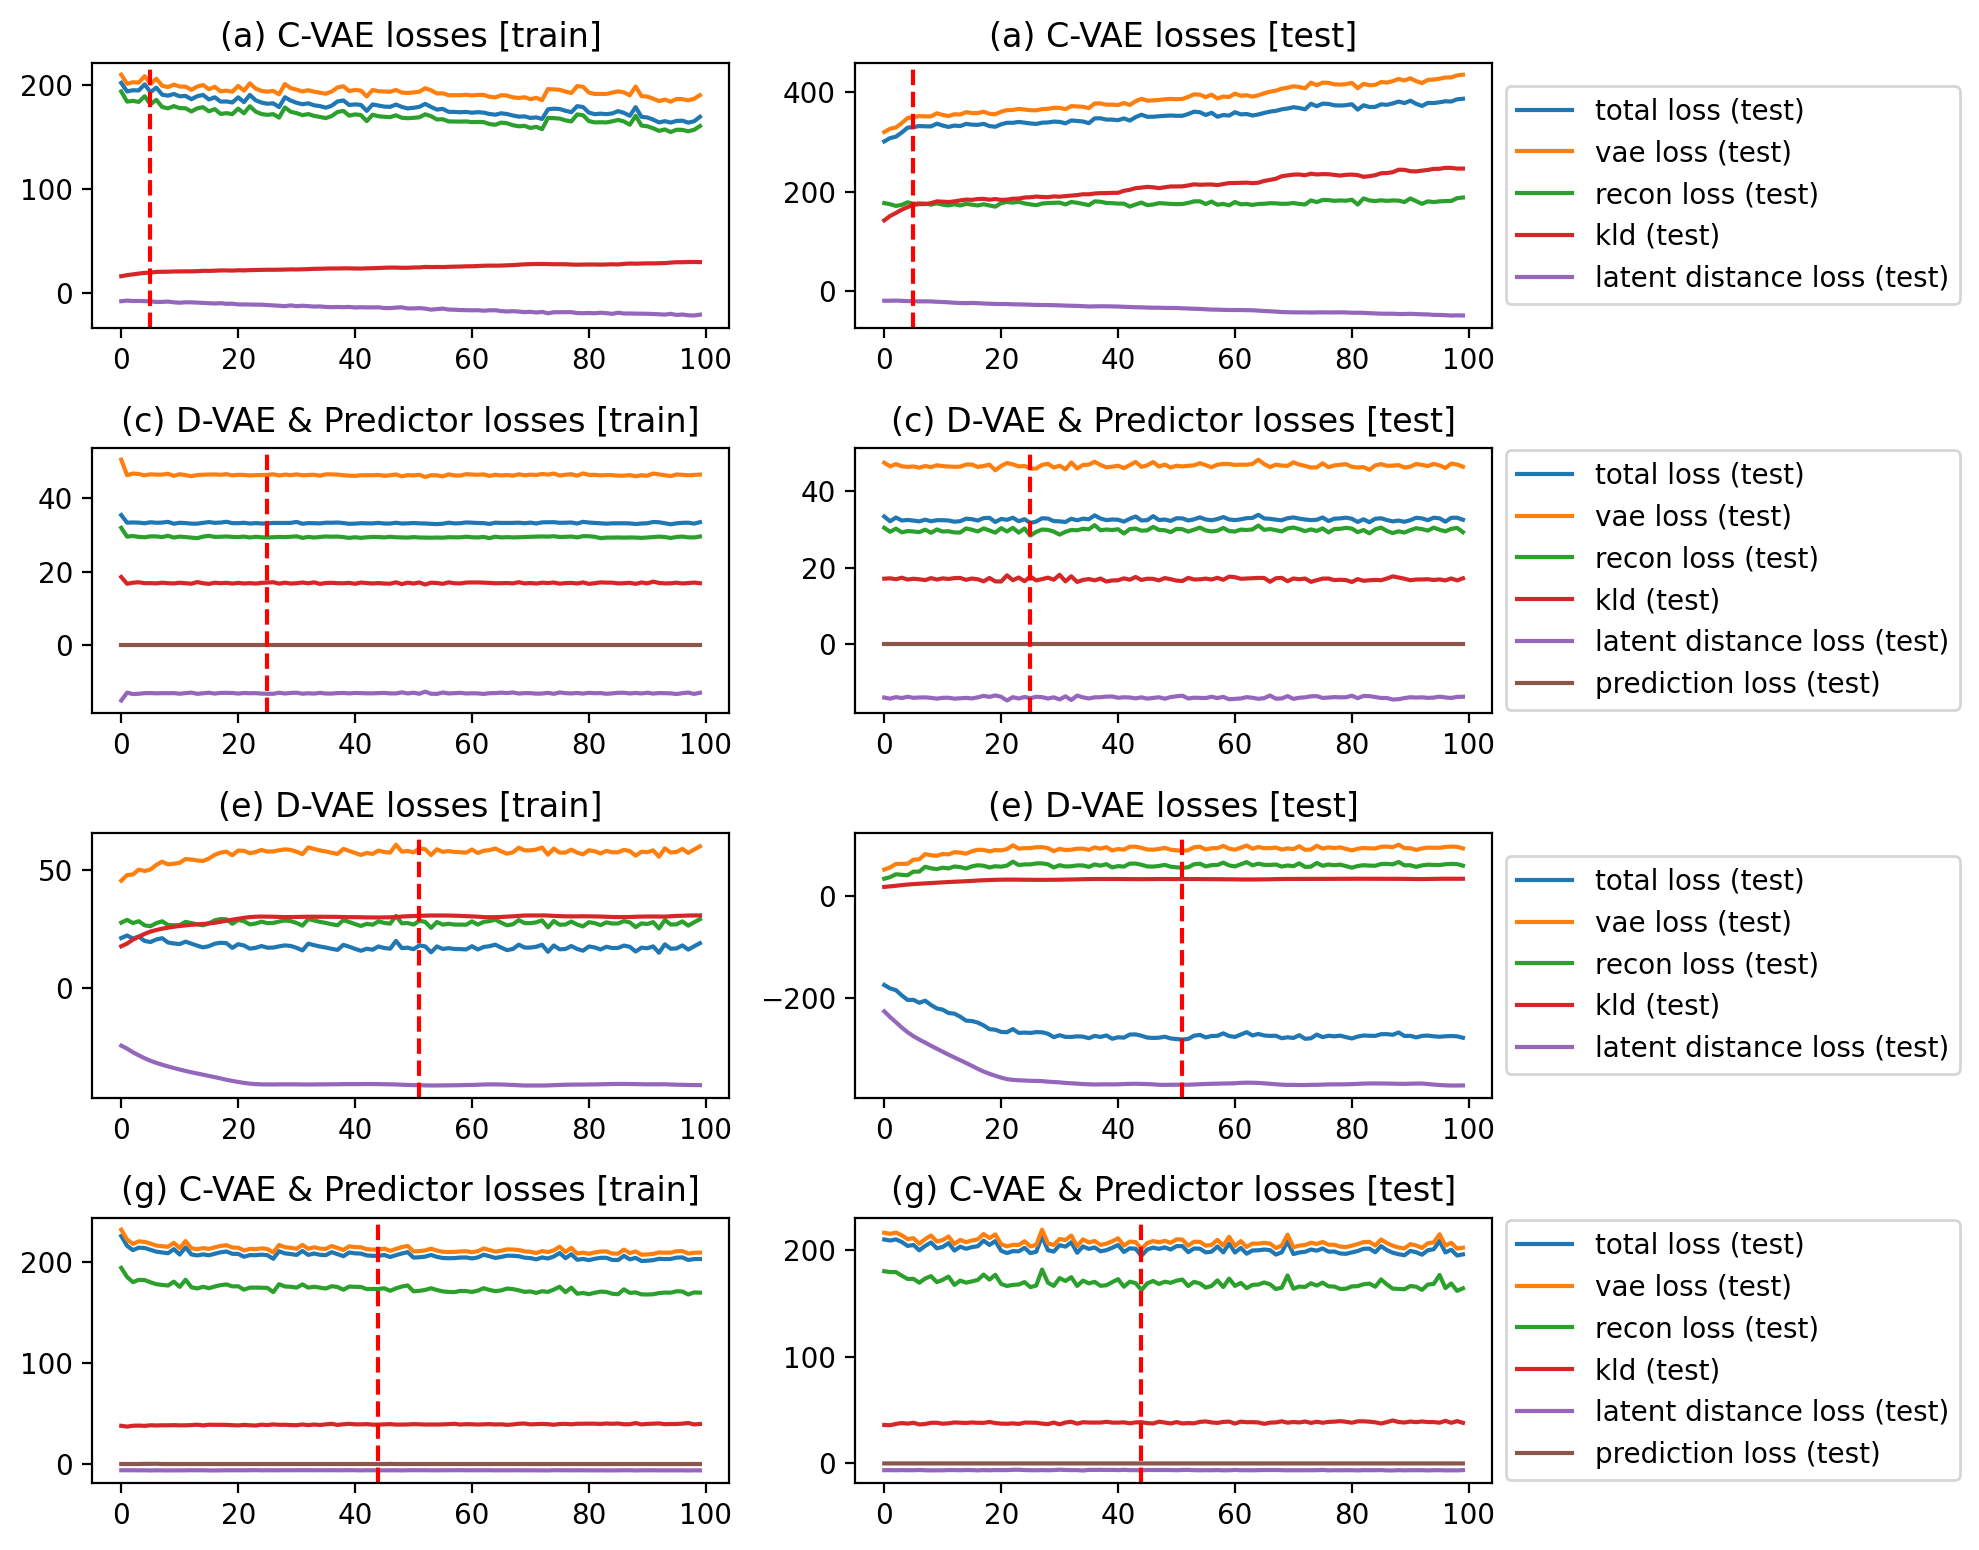

In [87]:
for k in range(K):
    print(f'k = {k}:')
    for b in range(n_rounds):
        print(f'round {b}:')
        plot_training_losses_train_test_2cols(losses_train_hist_list[b][k], best_epoch_1round = best_epos_list[b][k],
                                              plot_save_path=f'scripts_model/plots/simu2_3clusters_losses_b{b}_k{k}.png')